In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from multiple_attacks import * 
import pickle
from utils.viewer import show_batch
import matplotlib.pyplot as plt
from utils.mmd import MMD_torch

In [2]:
train_set, test_set = data_loader.get_data()
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
class NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        num_channels = 8

        self.conv = nn.Sequential(

            nn.Conv2d(1, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True)

        )
        self.fc1 = nn.Linear(num_channels * 4 ** 2, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        convolved = self.conv(x)
        after_fc1 = self.fc1(convolved.view(convolved.size(0), -1))
        output = self.fc2(after_fc1)
        return output
    
    def encode(self, x):
        
        convolved = self.conv(x)
        code = self.fc1(convolved.view(convolved.size(0), -1))
        
        return code
         


In [4]:

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)

first_batch = next(iter(train_loader))
first_images, first_labels = first_batch 

print(first_images.dtype)



torch.float32


In [5]:
#model = NeuralModel()
#train_model(model, train_loader)
#test_model(model, test_loader)

In [6]:
eps = 0.3

In [7]:
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
# #acc, adv_examples = test_attack(model, device, train_loader, epsilon=eps)

In [8]:
#print(len(adv_examples))

In [9]:
# with open('models/train_adv_examples.pkl', 'wb') as f:
#     pickle.dump(adv_examples, f)

In [10]:
with open('models/train_adv_examples.pkl', 'rb') as f:
    adv_examples = pickle.load(f)

In [11]:
true_labels =[]
adv_labels = [] 
adv_images =[]

In [12]:
for example in adv_examples:
    true_l, adv_l, adv_img = example
    
    true_labels.append(true_l)
    adv_labels.append(adv_l)
    adv_images.append(adv_img)

In [13]:
true_labels = torch.Tensor(true_labels).long()
adv_images = torch.Tensor(adv_images).reshape(-1,1,28,28)

In [14]:
b_size = 60
training_data = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_size)
print(len(train_loader))

1000


In [15]:
train_loader_iter = iter(train_loader)

for b in range (0, len(train_loader)*b_size, b_size):
    batch_images, batch_labels = next(train_loader_iter)
    training_data.append((batch_images, adv_images[b: b+b_size], true_labels[b: b+b_size]))

60
60
60


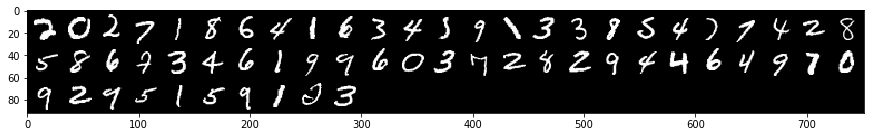

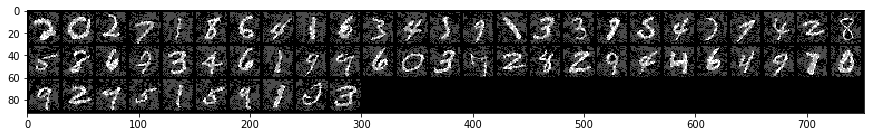

tensor([7, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 1, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 9, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 7, 5, 1, 5, 9, 1, 2, 3])


In [16]:
training_data_iter = iter(training_data)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
a,b,c = b1

print(len(a))
print(len(b))
print(len(c))

show_batch(a)
show_batch(b)
print(c)

In [17]:
def train_model(model, train_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    print("training ...")
    for epoch in range(n_epochs):
        for batch in train_data:
            batch_images, adv_images, batch_labels = batch

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            adv_images = adv_images.to(device)
            
            batch_output = model(batch_images)
            
            latent_1 = model.encode(batch_images)
            latent_2 = model.encode(adv_images)
            
            down_stream_loss = criterion(batch_output, batch_labels)
            representation_loss = MMD_Loss(latent_1, latent_2)
            
            total_loss = down_stream_loss + 100*representation_loss
            
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            print("The classification loss after processing this batch is: ", down_stream_loss.item())
            print("The representation loss after processing this batch is: ", representation_loss.item())
            print("")
            
    print("Done training..")
    print("=*="*20)
    return model



In [18]:

def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [19]:
modelMM = NeuralModel()
model = train_model(modelMM, training_data)

training ...
The classification loss after processing this batch is:  2.321028232574463
The representation loss after processing this batch is:  0.03902006149291992

The classification loss after processing this batch is:  2.2999541759490967
The representation loss after processing this batch is:  0.035895586013793945

The classification loss after processing this batch is:  2.3489716053009033
The representation loss after processing this batch is:  0.04436624050140381

The classification loss after processing this batch is:  2.310011625289917
The representation loss after processing this batch is:  0.03585779666900635

The classification loss after processing this batch is:  2.305407762527466
The representation loss after processing this batch is:  0.026587843894958496

The classification loss after processing this batch is:  2.3219268321990967
The representation loss after processing this batch is:  0.026927411556243896

The classification loss after processing this batch is:  2.3370

The classification loss after processing this batch is:  2.241546392440796
The representation loss after processing this batch is:  0.026256263256072998

The classification loss after processing this batch is:  2.2036163806915283
The representation loss after processing this batch is:  0.026196956634521484

The classification loss after processing this batch is:  2.232673406600952
The representation loss after processing this batch is:  0.02695128321647644

The classification loss after processing this batch is:  2.2012131214141846
The representation loss after processing this batch is:  0.0239560604095459

The classification loss after processing this batch is:  2.2535951137542725
The representation loss after processing this batch is:  0.020803213119506836

The classification loss after processing this batch is:  2.2262065410614014
The representation loss after processing this batch is:  0.023197442293167114

The classification loss after processing this batch is:  2.217569589614868


The classification loss after processing this batch is:  2.0201382637023926
The representation loss after processing this batch is:  0.017597079277038574

The classification loss after processing this batch is:  2.007007122039795
The representation loss after processing this batch is:  0.01628682017326355

The classification loss after processing this batch is:  2.1211044788360596
The representation loss after processing this batch is:  0.02180725336074829

The classification loss after processing this batch is:  2.0787503719329834
The representation loss after processing this batch is:  0.016749173402786255

The classification loss after processing this batch is:  2.0181987285614014
The representation loss after processing this batch is:  0.016603946685791016

The classification loss after processing this batch is:  2.132784366607666
The representation loss after processing this batch is:  0.017755717039108276

The classification loss after processing this batch is:  2.041926860809326

The classification loss after processing this batch is:  1.7809020280838013
The representation loss after processing this batch is:  0.010790005326271057

The classification loss after processing this batch is:  1.782267689704895
The representation loss after processing this batch is:  0.011951714754104614

The classification loss after processing this batch is:  1.8216233253479004
The representation loss after processing this batch is:  0.010100036859512329

The classification loss after processing this batch is:  1.8006664514541626
The representation loss after processing this batch is:  0.009083852171897888

The classification loss after processing this batch is:  1.76680326461792
The representation loss after processing this batch is:  0.010738328099250793

The classification loss after processing this batch is:  1.7922358512878418
The representation loss after processing this batch is:  0.01394614577293396

The classification loss after processing this batch is:  1.837177038192749

The classification loss after processing this batch is:  1.501625895500183
The representation loss after processing this batch is:  0.009296029806137085

The classification loss after processing this batch is:  1.4976801872253418
The representation loss after processing this batch is:  0.00842195749282837

The classification loss after processing this batch is:  1.4988924264907837
The representation loss after processing this batch is:  0.007884025573730469

The classification loss after processing this batch is:  1.4227217435836792
The representation loss after processing this batch is:  0.008914954960346222

The classification loss after processing this batch is:  1.3621509075164795
The representation loss after processing this batch is:  0.008167237043380737

The classification loss after processing this batch is:  1.4284199476242065
The representation loss after processing this batch is:  0.007760822772979736

The classification loss after processing this batch is:  1.4518151283264

The classification loss after processing this batch is:  1.3064051866531372
The representation loss after processing this batch is:  0.006991192698478699

The classification loss after processing this batch is:  1.408437728881836
The representation loss after processing this batch is:  0.009036153554916382

The classification loss after processing this batch is:  1.2944977283477783
The representation loss after processing this batch is:  0.00717463344335556

The classification loss after processing this batch is:  1.1912959814071655
The representation loss after processing this batch is:  0.0070342570543289185

The classification loss after processing this batch is:  1.2764594554901123
The representation loss after processing this batch is:  0.007364116609096527

The classification loss after processing this batch is:  1.2963155508041382
The representation loss after processing this batch is:  0.007217146456241608

The classification loss after processing this batch is:  1.294058561325

The classification loss after processing this batch is:  1.2015578746795654
The representation loss after processing this batch is:  0.0054181963205337524

The classification loss after processing this batch is:  1.1901872158050537
The representation loss after processing this batch is:  0.00653211772441864

The classification loss after processing this batch is:  1.304692029953003
The representation loss after processing this batch is:  0.0068346112966537476

The classification loss after processing this batch is:  1.0672515630722046
The representation loss after processing this batch is:  0.0063431113958358765

The classification loss after processing this batch is:  1.0667839050292969
The representation loss after processing this batch is:  0.006507217884063721

The classification loss after processing this batch is:  1.0416171550750732
The representation loss after processing this batch is:  0.008298516273498535

The classification loss after processing this batch is:  1.0225390195

The classification loss after processing this batch is:  0.9465147852897644
The representation loss after processing this batch is:  0.006362207233905792

The classification loss after processing this batch is:  0.9125062227249146
The representation loss after processing this batch is:  0.006221167743206024

The classification loss after processing this batch is:  0.866244912147522
The representation loss after processing this batch is:  0.004889152944087982

The classification loss after processing this batch is:  0.9308235049247742
The representation loss after processing this batch is:  0.005390673875808716

The classification loss after processing this batch is:  0.8750340938568115
The representation loss after processing this batch is:  0.005001381039619446

The classification loss after processing this batch is:  1.0029152631759644
The representation loss after processing this batch is:  0.0060088783502578735

The classification loss after processing this batch is:  0.87430608272

The classification loss after processing this batch is:  0.6088964343070984
The representation loss after processing this batch is:  0.0055856853723526

The classification loss after processing this batch is:  0.8745652437210083
The representation loss after processing this batch is:  0.005927786231040955

The classification loss after processing this batch is:  0.6383997797966003
The representation loss after processing this batch is:  0.006074719130992889

The classification loss after processing this batch is:  1.0486242771148682
The representation loss after processing this batch is:  0.005483865737915039

The classification loss after processing this batch is:  0.7197826504707336
The representation loss after processing this batch is:  0.005813203752040863

The classification loss after processing this batch is:  0.8625180125236511
The representation loss after processing this batch is:  0.006758332252502441

The classification loss after processing this batch is:  0.9148956537246

The classification loss after processing this batch is:  0.5628960728645325
The representation loss after processing this batch is:  0.005657307803630829

The classification loss after processing this batch is:  0.7908246517181396
The representation loss after processing this batch is:  0.005200475454330444

The classification loss after processing this batch is:  0.8109177947044373
The representation loss after processing this batch is:  0.005132615566253662

The classification loss after processing this batch is:  0.7380945086479187
The representation loss after processing this batch is:  0.005834572017192841

The classification loss after processing this batch is:  0.7150686383247375
The representation loss after processing this batch is:  0.004902966320514679

The classification loss after processing this batch is:  0.7588294148445129
The representation loss after processing this batch is:  0.006221011281013489

The classification loss after processing this batch is:  0.76240879297

The classification loss after processing this batch is:  0.6385582685470581
The representation loss after processing this batch is:  0.005069606006145477

The classification loss after processing this batch is:  0.551762044429779
The representation loss after processing this batch is:  0.004823312163352966

The classification loss after processing this batch is:  0.6141067147254944
The representation loss after processing this batch is:  0.005453471094369888

The classification loss after processing this batch is:  0.8114084005355835
The representation loss after processing this batch is:  0.005888685584068298

The classification loss after processing this batch is:  0.7341282963752747
The representation loss after processing this batch is:  0.005352891981601715

The classification loss after processing this batch is:  0.7418359518051147
The representation loss after processing this batch is:  0.004761781543493271

The classification loss after processing this batch is:  0.651770889759

The classification loss after processing this batch is:  0.4589027166366577
The representation loss after processing this batch is:  0.004915915429592133

The classification loss after processing this batch is:  0.4311680793762207
The representation loss after processing this batch is:  0.0048034414649009705

The classification loss after processing this batch is:  0.5325857400894165
The representation loss after processing this batch is:  0.003914836794137955

The classification loss after processing this batch is:  0.7000176310539246
The representation loss after processing this batch is:  0.005101453512907028

The classification loss after processing this batch is:  0.6984103322029114
The representation loss after processing this batch is:  0.005141198635101318

The classification loss after processing this batch is:  0.4446788430213928
The representation loss after processing this batch is:  0.005406409502029419

The classification loss after processing this batch is:  0.5892475843

The classification loss after processing this batch is:  0.44866427779197693
The representation loss after processing this batch is:  0.004569068551063538

The classification loss after processing this batch is:  0.3174886107444763
The representation loss after processing this batch is:  0.00484815239906311

The classification loss after processing this batch is:  0.41130104660987854
The representation loss after processing this batch is:  0.004546329379081726

The classification loss after processing this batch is:  0.6797171235084534
The representation loss after processing this batch is:  0.005137033760547638

The classification loss after processing this batch is:  0.7255175113677979
The representation loss after processing this batch is:  0.004928193986415863

The classification loss after processing this batch is:  0.6979909539222717
The representation loss after processing this batch is:  0.004784028977155685

The classification loss after processing this batch is:  0.5007038712

The classification loss after processing this batch is:  0.30189862847328186
The representation loss after processing this batch is:  0.004385992884635925

The classification loss after processing this batch is:  0.4907871186733246
The representation loss after processing this batch is:  0.0043974220752716064

The classification loss after processing this batch is:  0.5641287565231323
The representation loss after processing this batch is:  0.00400533527135849

The classification loss after processing this batch is:  0.37708956003189087
The representation loss after processing this batch is:  0.004844397306442261

The classification loss after processing this batch is:  0.41585788130760193
The representation loss after processing this batch is:  0.004225637763738632

The classification loss after processing this batch is:  0.41849184036254883
The representation loss after processing this batch is:  0.004434105008840561

The classification loss after processing this batch is:  0.2556169

The classification loss after processing this batch is:  0.4770078659057617
The representation loss after processing this batch is:  0.0046501606702804565

The classification loss after processing this batch is:  0.4739300310611725
The representation loss after processing this batch is:  0.003887750208377838

The classification loss after processing this batch is:  0.47684386372566223
The representation loss after processing this batch is:  0.005018778145313263

The classification loss after processing this batch is:  0.5883773565292358
The representation loss after processing this batch is:  0.0039842501282691956

The classification loss after processing this batch is:  0.3080628216266632
The representation loss after processing this batch is:  0.004258677363395691

The classification loss after processing this batch is:  0.29710838198661804
The representation loss after processing this batch is:  0.004872433841228485

The classification loss after processing this batch is:  0.3456224

The classification loss after processing this batch is:  0.46029990911483765
The representation loss after processing this batch is:  0.0038757584989070892

The classification loss after processing this batch is:  0.29214149713516235
The representation loss after processing this batch is:  0.004210062325000763

The classification loss after processing this batch is:  0.2137208878993988
The representation loss after processing this batch is:  0.004400670528411865

The classification loss after processing this batch is:  0.23692293465137482
The representation loss after processing this batch is:  0.004225939512252808

The classification loss after processing this batch is:  0.31117621064186096
The representation loss after processing this batch is:  0.004312843084335327

The classification loss after processing this batch is:  0.33077970147132874
The representation loss after processing this batch is:  0.0046043843030929565

The classification loss after processing this batch is:  0.4159

The classification loss after processing this batch is:  0.3669317066669464
The representation loss after processing this batch is:  0.004551917314529419

The classification loss after processing this batch is:  0.4431600272655487
The representation loss after processing this batch is:  0.003926798701286316

The classification loss after processing this batch is:  0.41931289434432983
The representation loss after processing this batch is:  0.004297934472560883

The classification loss after processing this batch is:  0.4953157305717468
The representation loss after processing this batch is:  0.00453900545835495

The classification loss after processing this batch is:  0.3701424300670624
The representation loss after processing this batch is:  0.004469573497772217

The classification loss after processing this batch is:  0.2892797589302063
The representation loss after processing this batch is:  0.0039038509130477905

The classification loss after processing this batch is:  0.2373691201

The classification loss after processing this batch is:  0.2600002884864807
The representation loss after processing this batch is:  0.0038065239787101746

The classification loss after processing this batch is:  0.24319304525852203
The representation loss after processing this batch is:  0.004098080098628998

The classification loss after processing this batch is:  0.2645944654941559
The representation loss after processing this batch is:  0.004151895642280579

The classification loss after processing this batch is:  0.32883819937705994
The representation loss after processing this batch is:  0.0032464303076267242

The classification loss after processing this batch is:  0.31048959493637085
The representation loss after processing this batch is:  0.0036386623978614807

The classification loss after processing this batch is:  0.4019225537776947
The representation loss after processing this batch is:  0.003984697163105011

The classification loss after processing this batch is:  0.58644

The classification loss after processing this batch is:  0.40256011486053467
The representation loss after processing this batch is:  0.004064679145812988

The classification loss after processing this batch is:  0.3225983679294586
The representation loss after processing this batch is:  0.0040778107941150665

The classification loss after processing this batch is:  0.31473883986473083
The representation loss after processing this batch is:  0.0038511157035827637

The classification loss after processing this batch is:  0.3553171753883362
The representation loss after processing this batch is:  0.004259571433067322

The classification loss after processing this batch is:  0.3763912618160248
The representation loss after processing this batch is:  0.00420127809047699

The classification loss after processing this batch is:  0.33497557044029236
The representation loss after processing this batch is:  0.0037411265075206757

The classification loss after processing this batch is:  0.452572

The classification loss after processing this batch is:  0.229685977101326
The representation loss after processing this batch is:  0.004194252192974091

The classification loss after processing this batch is:  0.261789470911026
The representation loss after processing this batch is:  0.004241853952407837

The classification loss after processing this batch is:  0.23162128031253815
The representation loss after processing this batch is:  0.003773726522922516

The classification loss after processing this batch is:  0.23923467099666595
The representation loss after processing this batch is:  0.00378340482711792

The classification loss after processing this batch is:  0.23225899040699005
The representation loss after processing this batch is:  0.004099756479263306

The classification loss after processing this batch is:  0.42960822582244873
The representation loss after processing this batch is:  0.004120089113712311

The classification loss after processing this batch is:  0.3462306261

The classification loss after processing this batch is:  0.36929091811180115
The representation loss after processing this batch is:  0.0032913759350776672

The classification loss after processing this batch is:  0.38942021131515503
The representation loss after processing this batch is:  0.00413396954536438

The classification loss after processing this batch is:  0.2073116898536682
The representation loss after processing this batch is:  0.003859870135784149

The classification loss after processing this batch is:  0.26297417283058167
The representation loss after processing this batch is:  0.0034370310604572296

The classification loss after processing this batch is:  0.4608396887779236
The representation loss after processing this batch is:  0.003882482647895813

The classification loss after processing this batch is:  0.5122905969619751
The representation loss after processing this batch is:  0.004044003784656525

The classification loss after processing this batch is:  0.4306074

The classification loss after processing this batch is:  0.3637191653251648
The representation loss after processing this batch is:  0.0036543793976306915

The classification loss after processing this batch is:  0.3407379686832428
The representation loss after processing this batch is:  0.0031027570366859436

The classification loss after processing this batch is:  0.21774159371852875
The representation loss after processing this batch is:  0.003752201795578003

The classification loss after processing this batch is:  0.28303220868110657
The representation loss after processing this batch is:  0.00416158139705658

The classification loss after processing this batch is:  0.3564583361148834
The representation loss after processing this batch is:  0.00394786149263382

The classification loss after processing this batch is:  0.2746336758136749
The representation loss after processing this batch is:  0.0039479658007621765

The classification loss after processing this batch is:  0.59160500

The classification loss after processing this batch is:  0.3115603029727936
The representation loss after processing this batch is:  0.0031547583639621735

The classification loss after processing this batch is:  0.32119935750961304
The representation loss after processing this batch is:  0.004065379500389099

The classification loss after processing this batch is:  0.3901374638080597
The representation loss after processing this batch is:  0.004291728138923645

The classification loss after processing this batch is:  0.3113712966442108
The representation loss after processing this batch is:  0.003864191472530365

The classification loss after processing this batch is:  0.28458866477012634
The representation loss after processing this batch is:  0.004064671695232391

The classification loss after processing this batch is:  0.5648477077484131
The representation loss after processing this batch is:  0.00379953533411026

The classification loss after processing this batch is:  0.415522396

The classification loss after processing this batch is:  0.37953951954841614
The representation loss after processing this batch is:  0.003478020429611206

The classification loss after processing this batch is:  0.31251904368400574
The representation loss after processing this batch is:  0.0031726211309432983

The classification loss after processing this batch is:  0.2984688878059387
The representation loss after processing this batch is:  0.0035357624292373657

The classification loss after processing this batch is:  0.2942071259021759
The representation loss after processing this batch is:  0.0032544583082199097

The classification loss after processing this batch is:  0.28249022364616394
The representation loss after processing this batch is:  0.00394158810377121

The classification loss after processing this batch is:  0.2885337769985199
The representation loss after processing this batch is:  0.003226138651371002

The classification loss after processing this batch is:  0.279806

The classification loss after processing this batch is:  0.1330871731042862
The representation loss after processing this batch is:  0.003923185169696808

The classification loss after processing this batch is:  0.25568142533302307
The representation loss after processing this batch is:  0.0032043978571891785

The classification loss after processing this batch is:  0.21741387248039246
The representation loss after processing this batch is:  0.0037779435515403748

The classification loss after processing this batch is:  0.15511268377304077
The representation loss after processing this batch is:  0.003093905746936798

The classification loss after processing this batch is:  0.18178482353687286
The representation loss after processing this batch is:  0.00354168564081192

The classification loss after processing this batch is:  0.1862984299659729
The representation loss after processing this batch is:  0.0036728978157043457

The classification loss after processing this batch is:  0.17117

The classification loss after processing this batch is:  0.4042713940143585
The representation loss after processing this batch is:  0.003754459321498871

The classification loss after processing this batch is:  0.36358413100242615
The representation loss after processing this batch is:  0.004328019917011261

The classification loss after processing this batch is:  0.20321711897850037
The representation loss after processing this batch is:  0.0031280703842639923

The classification loss after processing this batch is:  0.3542409837245941
The representation loss after processing this batch is:  0.0029387101531028748

The classification loss after processing this batch is:  0.18262876570224762
The representation loss after processing this batch is:  0.003205418586730957

The classification loss after processing this batch is:  0.15932942926883698
The representation loss after processing this batch is:  0.0031743422150611877

The classification loss after processing this batch is:  0.2320

The classification loss after processing this batch is:  0.16923853754997253
The representation loss after processing this batch is:  0.0034313462674617767

The classification loss after processing this batch is:  0.2785544991493225
The representation loss after processing this batch is:  0.003944478929042816

The classification loss after processing this batch is:  0.2977491617202759
The representation loss after processing this batch is:  0.0033882521092891693

The classification loss after processing this batch is:  0.2915535271167755
The representation loss after processing this batch is:  0.003085888922214508

The classification loss after processing this batch is:  0.3418387174606323
The representation loss after processing this batch is:  0.0030561089515686035

The classification loss after processing this batch is:  0.41577911376953125
The representation loss after processing this batch is:  0.0033413395285606384

The classification loss after processing this batch is:  0.26809

The classification loss after processing this batch is:  0.12768305838108063
The representation loss after processing this batch is:  0.003159821033477783

The classification loss after processing this batch is:  0.16675134003162384
The representation loss after processing this batch is:  0.003153979778289795

The classification loss after processing this batch is:  0.17696210741996765
The representation loss after processing this batch is:  0.003261275589466095

The classification loss after processing this batch is:  0.15011145174503326
The representation loss after processing this batch is:  0.003326892852783203

The classification loss after processing this batch is:  0.2320438027381897
The representation loss after processing this batch is:  0.002829458564519882

The classification loss after processing this batch is:  0.22980280220508575
The representation loss after processing this batch is:  0.003177538514137268

The classification loss after processing this batch is:  0.299015

The classification loss after processing this batch is:  0.25065886974334717
The representation loss after processing this batch is:  0.0030169636011123657

The classification loss after processing this batch is:  0.20621098577976227
The representation loss after processing this batch is:  0.0033199340105056763

The classification loss after processing this batch is:  0.24069984257221222
The representation loss after processing this batch is:  0.003264985978603363

The classification loss after processing this batch is:  0.28472474217414856
The representation loss after processing this batch is:  0.0033317282795906067

The classification loss after processing this batch is:  0.23759451508522034
The representation loss after processing this batch is:  0.0033056288957595825

The classification loss after processing this batch is:  0.20892399549484253
The representation loss after processing this batch is:  0.003364957869052887

The classification loss after processing this batch is:  0.2

The representation loss after processing this batch is:  0.002857610583305359

The classification loss after processing this batch is:  0.42071011662483215
The representation loss after processing this batch is:  0.00351908802986145

The classification loss after processing this batch is:  0.1785309761762619
The representation loss after processing this batch is:  0.0033687129616737366

The classification loss after processing this batch is:  0.12530213594436646
The representation loss after processing this batch is:  0.0039057657122612

The classification loss after processing this batch is:  0.16751892864704132
The representation loss after processing this batch is:  0.0036965012550354004

The classification loss after processing this batch is:  0.12262283265590668
The representation loss after processing this batch is:  0.004505537450313568

The classification loss after processing this batch is:  0.2434910386800766
The representation loss after processing this batch is:  0.00312090

The classification loss after processing this batch is:  0.18253715336322784
The representation loss after processing this batch is:  0.0030911974608898163

The classification loss after processing this batch is:  0.21221381425857544
The representation loss after processing this batch is:  0.0031372234225273132

The classification loss after processing this batch is:  0.1528402715921402
The representation loss after processing this batch is:  0.0034325681626796722

The classification loss after processing this batch is:  0.27263686060905457
The representation loss after processing this batch is:  0.003795325756072998

The classification loss after processing this batch is:  0.21084553003311157
The representation loss after processing this batch is:  0.002928752452135086

The classification loss after processing this batch is:  0.13399797677993774
The representation loss after processing this batch is:  0.0035325810313224792

The classification loss after processing this batch is:  0.35

The classification loss after processing this batch is:  0.24923385679721832
The representation loss after processing this batch is:  0.0027799084782600403

The classification loss after processing this batch is:  0.2291872352361679
The representation loss after processing this batch is:  0.0032225437462329865

The classification loss after processing this batch is:  0.2623627483844757
The representation loss after processing this batch is:  0.0033668875694274902

The classification loss after processing this batch is:  0.18736214935779572
The representation loss after processing this batch is:  0.0029078423976898193

The classification loss after processing this batch is:  0.32810264825820923
The representation loss after processing this batch is:  0.003180369734764099

The classification loss after processing this batch is:  0.32637038826942444
The representation loss after processing this batch is:  0.003285035490989685

The classification loss after processing this batch is:  0.252

The classification loss after processing this batch is:  0.2578827738761902
The representation loss after processing this batch is:  0.0032782703638076782

The classification loss after processing this batch is:  0.1881525069475174
The representation loss after processing this batch is:  0.003421477973461151

The classification loss after processing this batch is:  0.2800236940383911
The representation loss after processing this batch is:  0.0034897886216640472

The classification loss after processing this batch is:  0.17703333497047424
The representation loss after processing this batch is:  0.00301186740398407

The classification loss after processing this batch is:  0.23419030010700226
The representation loss after processing this batch is:  0.0029488354921340942

The classification loss after processing this batch is:  0.1768646538257599
The representation loss after processing this batch is:  0.0032019615173339844

The classification loss after processing this batch is:  0.270512

The classification loss after processing this batch is:  0.23664237558841705
The representation loss after processing this batch is:  0.0030487775802612305

The classification loss after processing this batch is:  0.3472481369972229
The representation loss after processing this batch is:  0.003479529172182083

The classification loss after processing this batch is:  0.19652798771858215
The representation loss after processing this batch is:  0.003322076052427292

The classification loss after processing this batch is:  0.374152809381485
The representation loss after processing this batch is:  0.002806350588798523

The classification loss after processing this batch is:  0.14051327109336853
The representation loss after processing this batch is:  0.002898968756198883

The classification loss after processing this batch is:  0.186934694647789
The representation loss after processing this batch is:  0.0031208842992782593

The classification loss after processing this batch is:  0.13022388

The classification loss after processing this batch is:  0.40422284603118896
The representation loss after processing this batch is:  0.002939648926258087

The classification loss after processing this batch is:  0.27108579874038696
The representation loss after processing this batch is:  0.0027598589658737183

The classification loss after processing this batch is:  0.2465454488992691
The representation loss after processing this batch is:  0.002842959016561508

The classification loss after processing this batch is:  0.1778241991996765
The representation loss after processing this batch is:  0.0028696656227111816

The classification loss after processing this batch is:  0.15894915163516998
The representation loss after processing this batch is:  0.0027523115277290344

The classification loss after processing this batch is:  0.13278332352638245
The representation loss after processing this batch is:  0.0028929859399795532

The classification loss after processing this batch is:  0.228

The classification loss after processing this batch is:  0.31987258791923523
The representation loss after processing this batch is:  0.0033117756247520447

The classification loss after processing this batch is:  0.14514295756816864
The representation loss after processing this batch is:  0.0034453123807907104

The classification loss after processing this batch is:  0.15551236271858215
The representation loss after processing this batch is:  0.0027899928390979767

The classification loss after processing this batch is:  0.30885398387908936
The representation loss after processing this batch is:  0.003108486533164978

The classification loss after processing this batch is:  0.29157397150993347
The representation loss after processing this batch is:  0.0028705596923828125

The classification loss after processing this batch is:  0.17156963050365448
The representation loss after processing this batch is:  0.0031721219420433044

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.13537754118442535
The representation loss after processing this batch is:  0.0033988356590270996

The classification loss after processing this batch is:  0.27477753162384033
The representation loss after processing this batch is:  0.0027478113770484924

The classification loss after processing this batch is:  0.2013201266527176
The representation loss after processing this batch is:  0.002877764403820038

The classification loss after processing this batch is:  0.17616017162799835
The representation loss after processing this batch is:  0.002683579921722412

The classification loss after processing this batch is:  0.15143680572509766
The representation loss after processing this batch is:  0.0028814375400543213

The classification loss after processing this batch is:  0.25422072410583496
The representation loss after processing this batch is:  0.003225095570087433

The classification loss after processing this batch is:  0.133

The classification loss after processing this batch is:  0.38245758414268494
The representation loss after processing this batch is:  0.0030201002955436707

The classification loss after processing this batch is:  0.3737991452217102
The representation loss after processing this batch is:  0.002953067421913147

The classification loss after processing this batch is:  0.28923365473747253
The representation loss after processing this batch is:  0.003101915121078491

The classification loss after processing this batch is:  0.11678720265626907
The representation loss after processing this batch is:  0.0032279491424560547

The classification loss after processing this batch is:  0.08253779262304306
The representation loss after processing this batch is:  0.003210201859474182

The classification loss after processing this batch is:  0.1959267109632492
The representation loss after processing this batch is:  0.0031797215342521667

The classification loss after processing this batch is:  0.1229

The classification loss after processing this batch is:  0.21425527334213257
The representation loss after processing this batch is:  0.0038223788142204285

The classification loss after processing this batch is:  0.2019064724445343
The representation loss after processing this batch is:  0.0032845772802829742

The classification loss after processing this batch is:  0.2780681848526001
The representation loss after processing this batch is:  0.003015577793121338

The classification loss after processing this batch is:  0.21057789027690887
The representation loss after processing this batch is:  0.0030549094080924988

The classification loss after processing this batch is:  0.1942245215177536
The representation loss after processing this batch is:  0.0031957998871803284

The classification loss after processing this batch is:  0.1297444850206375
The representation loss after processing this batch is:  0.0038712844252586365

The classification loss after processing this batch is:  0.1137

The representation loss after processing this batch is:  0.002603307366371155

The classification loss after processing this batch is:  0.11914269626140594
The representation loss after processing this batch is:  0.003126673400402069

The classification loss after processing this batch is:  0.20602144300937653
The representation loss after processing this batch is:  0.0036182701587677

The classification loss after processing this batch is:  0.21148023009300232
The representation loss after processing this batch is:  0.00341903418302536

The classification loss after processing this batch is:  0.154164656996727
The representation loss after processing this batch is:  0.003755137324333191

The classification loss after processing this batch is:  0.18703173100948334
The representation loss after processing this batch is:  0.002979651093482971

The classification loss after processing this batch is:  0.18458887934684753
The representation loss after processing this batch is:  0.0029787942

The representation loss after processing this batch is:  0.00300394743680954

The classification loss after processing this batch is:  0.372875839471817
The representation loss after processing this batch is:  0.0028322190046310425

The classification loss after processing this batch is:  0.22424310445785522
The representation loss after processing this batch is:  0.002744067460298538

The classification loss after processing this batch is:  0.11003411561250687
The representation loss after processing this batch is:  0.0028597749769687653

The classification loss after processing this batch is:  0.12022001296281815
The representation loss after processing this batch is:  0.0033898726105690002

The classification loss after processing this batch is:  0.137755885720253
The representation loss after processing this batch is:  0.003165632486343384

The classification loss after processing this batch is:  0.14637158811092377
The representation loss after processing this batch is:  0.0032662

The classification loss after processing this batch is:  0.20443248748779297
The representation loss after processing this batch is:  0.0030704662203788757

The classification loss after processing this batch is:  0.20266875624656677
The representation loss after processing this batch is:  0.0035775601863861084

The classification loss after processing this batch is:  0.3047768175601959
The representation loss after processing this batch is:  0.00274016335606575

The classification loss after processing this batch is:  0.20730261504650116
The representation loss after processing this batch is:  0.0027657300233840942

The classification loss after processing this batch is:  0.06796108186244965
The representation loss after processing this batch is:  0.00309772789478302

The classification loss after processing this batch is:  0.1752428412437439
The representation loss after processing this batch is:  0.00277598574757576

The classification loss after processing this batch is:  0.3859221

The classification loss after processing this batch is:  0.138570174574852
The representation loss after processing this batch is:  0.0031022056937217712

The classification loss after processing this batch is:  0.1098315566778183
The representation loss after processing this batch is:  0.0028268471360206604

The classification loss after processing this batch is:  0.07564757764339447
The representation loss after processing this batch is:  0.003482051193714142

The classification loss after processing this batch is:  0.2111610621213913
The representation loss after processing this batch is:  0.002917114645242691

The classification loss after processing this batch is:  0.2578680217266083
The representation loss after processing this batch is:  0.002904452383518219

The classification loss after processing this batch is:  0.12744887173175812
The representation loss after processing this batch is:  0.003105156123638153

The classification loss after processing this batch is:  0.16286568

The classification loss after processing this batch is:  0.13545452058315277
The representation loss after processing this batch is:  0.0025949254631996155

The classification loss after processing this batch is:  0.211440309882164
The representation loss after processing this batch is:  0.0029337555170059204

The classification loss after processing this batch is:  0.2383878082036972
The representation loss after processing this batch is:  0.0026813186705112457

The classification loss after processing this batch is:  0.24613304436206818
The representation loss after processing this batch is:  0.0030143633484840393

The classification loss after processing this batch is:  0.2347269058227539
The representation loss after processing this batch is:  0.0027673542499542236

The classification loss after processing this batch is:  0.23486825823783875
The representation loss after processing this batch is:  0.003305785357952118

The classification loss after processing this batch is:  0.3562

The classification loss after processing this batch is:  0.35330137610435486
The representation loss after processing this batch is:  0.002874411642551422

The classification loss after processing this batch is:  0.14552466571331024
The representation loss after processing this batch is:  0.002673868089914322

The classification loss after processing this batch is:  0.13191699981689453
The representation loss after processing this batch is:  0.0028965845704078674

The classification loss after processing this batch is:  0.14223365485668182
The representation loss after processing this batch is:  0.0028172284364700317

The classification loss after processing this batch is:  0.21469077467918396
The representation loss after processing this batch is:  0.002738896757364273

The classification loss after processing this batch is:  0.1507931649684906
The representation loss after processing this batch is:  0.0030331164598464966

The classification loss after processing this batch is:  0.084

The representation loss after processing this batch is:  0.0026766955852508545

The classification loss after processing this batch is:  0.1666446179151535
The representation loss after processing this batch is:  0.002899467945098877

The classification loss after processing this batch is:  0.2195308953523636
The representation loss after processing this batch is:  0.0029075518250465393

The classification loss after processing this batch is:  0.18356582522392273
The representation loss after processing this batch is:  0.0032515302300453186

The classification loss after processing this batch is:  0.23582573235034943
The representation loss after processing this batch is:  0.002826165407896042

The classification loss after processing this batch is:  0.2825860381126404
The representation loss after processing this batch is:  0.003438815474510193

The classification loss after processing this batch is:  0.2457025796175003
The representation loss after processing this batch is:  0.003207

The classification loss after processing this batch is:  0.2709047198295593
The representation loss after processing this batch is:  0.003837898373603821

The classification loss after processing this batch is:  0.18480592966079712
The representation loss after processing this batch is:  0.0034183859825134277

The classification loss after processing this batch is:  0.18224003911018372
The representation loss after processing this batch is:  0.002681620419025421

The classification loss after processing this batch is:  0.1568872481584549
The representation loss after processing this batch is:  0.0028608813881874084

The classification loss after processing this batch is:  0.09335605055093765
The representation loss after processing this batch is:  0.002642296254634857

The classification loss after processing this batch is:  0.10183979570865631
The representation loss after processing this batch is:  0.0033046603202819824

The classification loss after processing this batch is:  0.1240

The representation loss after processing this batch is:  0.003389008343219757

The classification loss after processing this batch is:  0.1518455147743225
The representation loss after processing this batch is:  0.003224886953830719

The classification loss after processing this batch is:  0.2228921353816986
The representation loss after processing this batch is:  0.0027664564549922943

The classification loss after processing this batch is:  0.19479216635227203
The representation loss after processing this batch is:  0.0028714053332805634

The classification loss after processing this batch is:  0.1880238801240921
The representation loss after processing this batch is:  0.0032285600900650024

The classification loss after processing this batch is:  0.23253662884235382
The representation loss after processing this batch is:  0.003229007124900818

The classification loss after processing this batch is:  0.16486181318759918
The representation loss after processing this batch is:  0.00306

The classification loss after processing this batch is:  0.24579808115959167
The representation loss after processing this batch is:  0.002852201461791992

The classification loss after processing this batch is:  0.14348196983337402
The representation loss after processing this batch is:  0.003890007734298706

The classification loss after processing this batch is:  0.19056768715381622
The representation loss after processing this batch is:  0.002776205539703369

The classification loss after processing this batch is:  0.15687057375907898
The representation loss after processing this batch is:  0.0025682374835014343

The classification loss after processing this batch is:  0.2174134999513626
The representation loss after processing this batch is:  0.002861037850379944

The classification loss after processing this batch is:  0.10874073952436447
The representation loss after processing this batch is:  0.0029838979244232178

The classification loss after processing this batch is:  0.1777

The classification loss after processing this batch is:  0.15564113855361938
The representation loss after processing this batch is:  0.0029561594128608704

The classification loss after processing this batch is:  0.13167300820350647
The representation loss after processing this batch is:  0.0033212900161743164

The classification loss after processing this batch is:  0.09860362857580185
The representation loss after processing this batch is:  0.002756137400865555

The classification loss after processing this batch is:  0.1923477202653885
The representation loss after processing this batch is:  0.0032396316528320312

The classification loss after processing this batch is:  0.2575036883354187
The representation loss after processing this batch is:  0.0033250898122787476

The classification loss after processing this batch is:  0.2272932380437851
The representation loss after processing this batch is:  0.0027898289263248444

The classification loss after processing this batch is:  0.211

The representation loss after processing this batch is:  0.0033471956849098206

The classification loss after processing this batch is:  0.12479957938194275
The representation loss after processing this batch is:  0.0028701871633529663

The classification loss after processing this batch is:  0.15429721772670746
The representation loss after processing this batch is:  0.003312245011329651

The classification loss after processing this batch is:  0.1035694032907486
The representation loss after processing this batch is:  0.0028378814458847046

The classification loss after processing this batch is:  0.09062525629997253
The representation loss after processing this batch is:  0.003343932330608368

The classification loss after processing this batch is:  0.10025563836097717
The representation loss after processing this batch is:  0.002850547432899475

The classification loss after processing this batch is:  0.09396020323038101
The representation loss after processing this batch is:  0.003

The classification loss after processing this batch is:  0.1082308292388916
The representation loss after processing this batch is:  0.0027805864810943604

The classification loss after processing this batch is:  0.2389642596244812
The representation loss after processing this batch is:  0.003124825656414032

The classification loss after processing this batch is:  0.22851009666919708
The representation loss after processing this batch is:  0.003227606415748596

The classification loss after processing this batch is:  0.17979417741298676
The representation loss after processing this batch is:  0.002873852849006653

The classification loss after processing this batch is:  0.07661435753107071
The representation loss after processing this batch is:  0.003121897578239441

The classification loss after processing this batch is:  0.14523956179618835
The representation loss after processing this batch is:  0.003112219274044037

The classification loss after processing this batch is:  0.161549

The classification loss after processing this batch is:  0.062000956386327744
The representation loss after processing this batch is:  0.0030037686228752136

The classification loss after processing this batch is:  0.1667979210615158
The representation loss after processing this batch is:  0.003481462597846985

The classification loss after processing this batch is:  0.13191701471805573
The representation loss after processing this batch is:  0.003046862781047821

The classification loss after processing this batch is:  0.08410106599330902
The representation loss after processing this batch is:  0.0028728358447551727

The classification loss after processing this batch is:  0.10976474732160568
The representation loss after processing this batch is:  0.00309918075799942

The classification loss after processing this batch is:  0.08662291616201401
The representation loss after processing this batch is:  0.002773575484752655

The classification loss after processing this batch is:  0.0747

The classification loss after processing this batch is:  0.12872152030467987
The representation loss after processing this batch is:  0.003176748752593994

The classification loss after processing this batch is:  0.13231238722801208
The representation loss after processing this batch is:  0.002649247646331787

The classification loss after processing this batch is:  0.12729951739311218
The representation loss after processing this batch is:  0.002954859286546707

The classification loss after processing this batch is:  0.18641187250614166
The representation loss after processing this batch is:  0.003381602466106415

The classification loss after processing this batch is:  0.14205637574195862
The representation loss after processing this batch is:  0.0029999203979969025

The classification loss after processing this batch is:  0.1793341338634491
The representation loss after processing this batch is:  0.003444913774728775

The classification loss after processing this batch is:  0.08341

The classification loss after processing this batch is:  0.19102860987186432
The representation loss after processing this batch is:  0.002920977771282196

The classification loss after processing this batch is:  0.24375773966312408
The representation loss after processing this batch is:  0.0027518942952156067

The classification loss after processing this batch is:  0.14240394532680511
The representation loss after processing this batch is:  0.0031055063009262085

The classification loss after processing this batch is:  0.17872454226016998
The representation loss after processing this batch is:  0.002664674073457718

The classification loss after processing this batch is:  0.15715180337429047
The representation loss after processing this batch is:  0.002864852547645569

The classification loss after processing this batch is:  0.25922688841819763
The representation loss after processing this batch is:  0.0034204162657260895

The classification loss after processing this batch is:  0.30

The classification loss after processing this batch is:  0.22832991182804108
The representation loss after processing this batch is:  0.002476729452610016

The classification loss after processing this batch is:  0.16760531067848206
The representation loss after processing this batch is:  0.0027115345001220703

The classification loss after processing this batch is:  0.1703367978334427
The representation loss after processing this batch is:  0.002965502440929413

The classification loss after processing this batch is:  0.10507076233625412
The representation loss after processing this batch is:  0.003189101815223694

The classification loss after processing this batch is:  0.05922210216522217
The representation loss after processing this batch is:  0.0031442493200302124

The classification loss after processing this batch is:  0.16930337250232697
The representation loss after processing this batch is:  0.0029783397912979126

The classification loss after processing this batch is:  0.132

The classification loss after processing this batch is:  0.3512369692325592
The representation loss after processing this batch is:  0.002942018210887909

The classification loss after processing this batch is:  0.21570277214050293
The representation loss after processing this batch is:  0.0030893534421920776

The classification loss after processing this batch is:  0.18360449373722076
The representation loss after processing this batch is:  0.0029335469007492065

The classification loss after processing this batch is:  0.12837105989456177
The representation loss after processing this batch is:  0.0035768821835517883

The classification loss after processing this batch is:  0.06362713873386383
The representation loss after processing this batch is:  0.0028999000787734985

The classification loss after processing this batch is:  0.2508062422275543
The representation loss after processing this batch is:  0.0027069374918937683

The classification loss after processing this batch is:  0.19

The classification loss after processing this batch is:  0.12127920985221863
The representation loss after processing this batch is:  0.002995632588863373

The classification loss after processing this batch is:  0.14068110287189484
The representation loss after processing this batch is:  0.0032581984996795654

The classification loss after processing this batch is:  0.18822231888771057
The representation loss after processing this batch is:  0.002697199583053589

The classification loss after processing this batch is:  0.11195716261863708
The representation loss after processing this batch is:  0.003145165741443634

The classification loss after processing this batch is:  0.13773204386234283
The representation loss after processing this batch is:  0.003115743398666382

The classification loss after processing this batch is:  0.24486348032951355
The representation loss after processing this batch is:  0.0029786452651023865

The classification loss after processing this batch is:  0.165

The classification loss after processing this batch is:  0.08139777183532715
The representation loss after processing this batch is:  0.003071241080760956

The classification loss after processing this batch is:  0.05489024147391319
The representation loss after processing this batch is:  0.0031970739364624023

The classification loss after processing this batch is:  0.08971217274665833
The representation loss after processing this batch is:  0.003418572247028351

The classification loss after processing this batch is:  0.10771739482879639
The representation loss after processing this batch is:  0.003768928349018097

The classification loss after processing this batch is:  0.04392990097403526
The representation loss after processing this batch is:  0.003980852663516998

The classification loss after processing this batch is:  0.06934328377246857
The representation loss after processing this batch is:  0.0032124891877174377

The classification loss after processing this batch is:  0.198

The classification loss after processing this batch is:  0.1516004502773285
The representation loss after processing this batch is:  0.0025240927934646606

The classification loss after processing this batch is:  0.1638144552707672
The representation loss after processing this batch is:  0.002729669213294983

The classification loss after processing this batch is:  0.10948168486356735
The representation loss after processing this batch is:  0.00259200856089592

The classification loss after processing this batch is:  0.11654064804315567
The representation loss after processing this batch is:  0.0025558583438396454

The classification loss after processing this batch is:  0.24016380310058594
The representation loss after processing this batch is:  0.0033125951886177063

The classification loss after processing this batch is:  0.08645831048488617
The representation loss after processing this batch is:  0.002796359360218048

The classification loss after processing this batch is:  0.16687

The classification loss after processing this batch is:  0.16554775834083557
The representation loss after processing this batch is:  0.002603389322757721

The classification loss after processing this batch is:  0.1394905298948288
The representation loss after processing this batch is:  0.0035687237977981567

The classification loss after processing this batch is:  0.10222610831260681
The representation loss after processing this batch is:  0.0028082728385925293

The classification loss after processing this batch is:  0.27470919489860535
The representation loss after processing this batch is:  0.003985852003097534

The classification loss after processing this batch is:  0.3018718361854553
The representation loss after processing this batch is:  0.0026165060698986053

The classification loss after processing this batch is:  0.1814262419939041
The representation loss after processing this batch is:  0.0029197633266448975

The classification loss after processing this batch is:  0.2704

The classification loss after processing this batch is:  0.2133139967918396
The representation loss after processing this batch is:  0.0028274431824684143

The classification loss after processing this batch is:  0.09361732751131058
The representation loss after processing this batch is:  0.002963319420814514

The classification loss after processing this batch is:  0.0945657417178154
The representation loss after processing this batch is:  0.0028227344155311584

The classification loss after processing this batch is:  0.07154535502195358
The representation loss after processing this batch is:  0.00260094553232193

The classification loss after processing this batch is:  0.26113995909690857
The representation loss after processing this batch is:  0.002732597291469574

The classification loss after processing this batch is:  0.1424117088317871
The representation loss after processing this batch is:  0.0028251856565475464

The classification loss after processing this batch is:  0.061005

The classification loss after processing this batch is:  0.16136957705020905
The representation loss after processing this batch is:  0.0027546361088752747

The classification loss after processing this batch is:  0.16804103553295135
The representation loss after processing this batch is:  0.0031955018639564514

The classification loss after processing this batch is:  0.09974474459886551
The representation loss after processing this batch is:  0.0029324591159820557

The classification loss after processing this batch is:  0.19515559077262878
The representation loss after processing this batch is:  0.0030285418033599854

The classification loss after processing this batch is:  0.1616213172674179
The representation loss after processing this batch is:  0.002831757068634033

The classification loss after processing this batch is:  0.12415584921836853
The representation loss after processing this batch is:  0.0024826563894748688

The classification loss after processing this batch is:  0.1

The representation loss after processing this batch is:  0.002717740833759308

The classification loss after processing this batch is:  0.06734710186719894
The representation loss after processing this batch is:  0.002601921558380127

The classification loss after processing this batch is:  0.11074811965227127
The representation loss after processing this batch is:  0.0028477609157562256

The classification loss after processing this batch is:  0.058478984981775284
The representation loss after processing this batch is:  0.002945415675640106

The classification loss after processing this batch is:  0.1972220093011856
The representation loss after processing this batch is:  0.002765186131000519

The classification loss after processing this batch is:  0.13840684294700623
The representation loss after processing this batch is:  0.002411443740129471

The classification loss after processing this batch is:  0.16533923149108887
The representation loss after processing this batch is:  0.0028

The classification loss after processing this batch is:  0.11996500939130783
The representation loss after processing this batch is:  0.002696022391319275

The classification loss after processing this batch is:  0.12140016257762909
The representation loss after processing this batch is:  0.002602122724056244

The classification loss after processing this batch is:  0.12363196909427643
The representation loss after processing this batch is:  0.0026721134781837463

The classification loss after processing this batch is:  0.18934999406337738
The representation loss after processing this batch is:  0.002690643072128296

The classification loss after processing this batch is:  0.16297391057014465
The representation loss after processing this batch is:  0.0025967657566070557

The classification loss after processing this batch is:  0.11557920277118683
The representation loss after processing this batch is:  0.0026264488697052

The classification loss after processing this batch is:  0.18754

The classification loss after processing this batch is:  0.14818337559700012
The representation loss after processing this batch is:  0.002984825521707535

The classification loss after processing this batch is:  0.10942146927118301
The representation loss after processing this batch is:  0.003015086054801941

The classification loss after processing this batch is:  0.3933645188808441
The representation loss after processing this batch is:  0.0033285915851593018

The classification loss after processing this batch is:  0.16238142549991608
The representation loss after processing this batch is:  0.0031184405088424683

The classification loss after processing this batch is:  0.22896817326545715
The representation loss after processing this batch is:  0.003553256392478943

The classification loss after processing this batch is:  0.11062566190958023
The representation loss after processing this batch is:  0.0025995224714279175

The classification loss after processing this batch is:  0.124

The classification loss after processing this batch is:  0.15189461410045624
The representation loss after processing this batch is:  0.0033101364970207214

The classification loss after processing this batch is:  0.1359388381242752
The representation loss after processing this batch is:  0.0032459571957588196

The classification loss after processing this batch is:  0.2676163911819458
The representation loss after processing this batch is:  0.0029839128255844116

The classification loss after processing this batch is:  0.23506473004817963
The representation loss after processing this batch is:  0.003360077738761902

The classification loss after processing this batch is:  0.1146756261587143
The representation loss after processing this batch is:  0.0028388649225234985

The classification loss after processing this batch is:  0.08699463307857513
The representation loss after processing this batch is:  0.0027675367891788483

The classification loss after processing this batch is:  0.117

The classification loss after processing this batch is:  0.1026553139090538
The representation loss after processing this batch is:  0.002904728055000305

The classification loss after processing this batch is:  0.21502746641635895
The representation loss after processing this batch is:  0.0027371644973754883

The classification loss after processing this batch is:  0.15113568305969238
The representation loss after processing this batch is:  0.0027003586292266846

The classification loss after processing this batch is:  0.16059939563274384
The representation loss after processing this batch is:  0.002819925546646118

The classification loss after processing this batch is:  0.16914300620555878
The representation loss after processing this batch is:  0.0027697384357452393

The classification loss after processing this batch is:  0.13349922001361847
The representation loss after processing this batch is:  0.003039442002773285

The classification loss after processing this batch is:  0.146

The classification loss after processing this batch is:  0.16392192244529724
The representation loss after processing this batch is:  0.002661287784576416

The classification loss after processing this batch is:  0.1341347098350525
The representation loss after processing this batch is:  0.002922661602497101

The classification loss after processing this batch is:  0.06651487201452255
The representation loss after processing this batch is:  0.0023878440260887146

The classification loss after processing this batch is:  0.1054908037185669
The representation loss after processing this batch is:  0.002939872443675995

The classification loss after processing this batch is:  0.10118276625871658
The representation loss after processing this batch is:  0.0028454959392547607

The classification loss after processing this batch is:  0.06860318034887314
The representation loss after processing this batch is:  0.0025597363710403442

The classification loss after processing this batch is:  0.2542

The classification loss after processing this batch is:  0.17739258706569672
The representation loss after processing this batch is:  0.003089509904384613

The classification loss after processing this batch is:  0.19947390258312225
The representation loss after processing this batch is:  0.00321333110332489

The classification loss after processing this batch is:  0.10143362730741501
The representation loss after processing this batch is:  0.002401493489742279

The classification loss after processing this batch is:  0.22225786745548248
The representation loss after processing this batch is:  0.002624835819005966

The classification loss after processing this batch is:  0.06827303767204285
The representation loss after processing this batch is:  0.0025780871510505676

The classification loss after processing this batch is:  0.08045120537281036
The representation loss after processing this batch is:  0.0028085336089134216

The classification loss after processing this batch is:  0.1174

The classification loss after processing this batch is:  0.13688591122627258
The representation loss after processing this batch is:  0.002808481454849243

The classification loss after processing this batch is:  0.16656433045864105
The representation loss after processing this batch is:  0.0029630884528160095

The classification loss after processing this batch is:  0.07330869138240814
The representation loss after processing this batch is:  0.0026108548045158386

The classification loss after processing this batch is:  0.06583358347415924
The representation loss after processing this batch is:  0.0026840977370738983

The classification loss after processing this batch is:  0.08120886981487274
The representation loss after processing this batch is:  0.0028874725103378296

The classification loss after processing this batch is:  0.18282486498355865
The representation loss after processing this batch is:  0.003318190574645996

The classification loss after processing this batch is:  0.2

The classification loss after processing this batch is:  0.07391247153282166
The representation loss after processing this batch is:  0.0030905231833457947

The classification loss after processing this batch is:  0.10614635795354843
The representation loss after processing this batch is:  0.002492383122444153

The classification loss after processing this batch is:  0.154202401638031
The representation loss after processing this batch is:  0.0026257820427417755

The classification loss after processing this batch is:  0.18660172820091248
The representation loss after processing this batch is:  0.002963908016681671

The classification loss after processing this batch is:  0.1180296465754509
The representation loss after processing this batch is:  0.0027721822261810303

The classification loss after processing this batch is:  0.11134118586778641
The representation loss after processing this batch is:  0.0026967301964759827

The classification loss after processing this batch is:  0.0597

The classification loss after processing this batch is:  0.05852150171995163
The representation loss after processing this batch is:  0.0025170743465423584

The classification loss after processing this batch is:  0.16568459570407867
The representation loss after processing this batch is:  0.0025676488876342773

The classification loss after processing this batch is:  0.06942501664161682
The representation loss after processing this batch is:  0.00302731990814209

The classification loss after processing this batch is:  0.15938276052474976
The representation loss after processing this batch is:  0.002827078104019165

The classification loss after processing this batch is:  0.10942713916301727
The representation loss after processing this batch is:  0.0029281824827194214

The classification loss after processing this batch is:  0.1069084033370018
The representation loss after processing this batch is:  0.0031078755855560303

The classification loss after processing this batch is:  0.168

The classification loss after processing this batch is:  0.19328604638576508
The representation loss after processing this batch is:  0.00240490585565567

The classification loss after processing this batch is:  0.17834778130054474
The representation loss after processing this batch is:  0.0026947930455207825

The classification loss after processing this batch is:  0.19781328737735748
The representation loss after processing this batch is:  0.002512909471988678

The classification loss after processing this batch is:  0.15483751893043518
The representation loss after processing this batch is:  0.0028958171606063843

The classification loss after processing this batch is:  0.23886850476264954
The representation loss after processing this batch is:  0.0028191134333610535

The classification loss after processing this batch is:  0.10567399859428406
The representation loss after processing this batch is:  0.0025921761989593506

The classification loss after processing this batch is:  0.08

The representation loss after processing this batch is:  0.0024698153138160706

The classification loss after processing this batch is:  0.11886367946863174
The representation loss after processing this batch is:  0.002756252884864807

The classification loss after processing this batch is:  0.22467222809791565
The representation loss after processing this batch is:  0.002879541367292404

The classification loss after processing this batch is:  0.15270286798477173
The representation loss after processing this batch is:  0.0028147846460342407

The classification loss after processing this batch is:  0.08385791629552841
The representation loss after processing this batch is:  0.002876643091440201

The classification loss after processing this batch is:  0.2601419687271118
The representation loss after processing this batch is:  0.003530532121658325

The classification loss after processing this batch is:  0.14488887786865234
The representation loss after processing this batch is:  0.0028

The classification loss after processing this batch is:  0.14156658947467804
The representation loss after processing this batch is:  0.002504222095012665

The classification loss after processing this batch is:  0.12287921458482742
The representation loss after processing this batch is:  0.0026963576674461365

The classification loss after processing this batch is:  0.08348876982927322
The representation loss after processing this batch is:  0.0023107677698135376

The classification loss after processing this batch is:  0.07520385086536407
The representation loss after processing this batch is:  0.0027287304401397705

The classification loss after processing this batch is:  0.13749001920223236
The representation loss after processing this batch is:  0.00252523273229599

The classification loss after processing this batch is:  0.1760486513376236
The representation loss after processing this batch is:  0.002357199788093567

The classification loss after processing this batch is:  0.0937

The classification loss after processing this batch is:  0.08247461169958115
The representation loss after processing this batch is:  0.0028322935104370117

The classification loss after processing this batch is:  0.06538267433643341
The representation loss after processing this batch is:  0.002969317138195038

The classification loss after processing this batch is:  0.0982220321893692
The representation loss after processing this batch is:  0.003188185393810272

The classification loss after processing this batch is:  0.10683798044919968
The representation loss after processing this batch is:  0.002842061221599579

The classification loss after processing this batch is:  0.15322443842887878
The representation loss after processing this batch is:  0.0028059594333171844

The classification loss after processing this batch is:  0.12736912071704865
The representation loss after processing this batch is:  0.002517193555831909

The classification loss after processing this batch is:  0.2166

The classification loss after processing this batch is:  0.04267760366201401
The representation loss after processing this batch is:  0.0029735714197158813

The classification loss after processing this batch is:  0.06640785187482834
The representation loss after processing this batch is:  0.0031590908765792847

The classification loss after processing this batch is:  0.12403019517660141
The representation loss after processing this batch is:  0.0024160444736480713

The classification loss after processing this batch is:  0.1781480610370636
The representation loss after processing this batch is:  0.002757050096988678

The classification loss after processing this batch is:  0.09142600744962692
The representation loss after processing this batch is:  0.0028149187564849854

The classification loss after processing this batch is:  0.07932625710964203
The representation loss after processing this batch is:  0.0026850849390029907

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.1406615674495697
The representation loss after processing this batch is:  0.0023960769176483154

The classification loss after processing this batch is:  0.12412254512310028
The representation loss after processing this batch is:  0.0028540492057800293

The classification loss after processing this batch is:  0.16899077594280243
The representation loss after processing this batch is:  0.0026353970170021057

The classification loss after processing this batch is:  0.11639455705881119
The representation loss after processing this batch is:  0.0026792213320732117

The classification loss after processing this batch is:  0.12993621826171875
The representation loss after processing this batch is:  0.003183715045452118

The classification loss after processing this batch is:  0.1040048897266388
The representation loss after processing this batch is:  0.002970270812511444

The classification loss after processing this batch is:  0.134

The classification loss after processing this batch is:  0.08621744811534882
The representation loss after processing this batch is:  0.003140978515148163

The classification loss after processing this batch is:  0.15683265030384064
The representation loss after processing this batch is:  0.00296860933303833

The classification loss after processing this batch is:  0.18574737012386322
The representation loss after processing this batch is:  0.0026143789291381836

The classification loss after processing this batch is:  0.0960383415222168
The representation loss after processing this batch is:  0.0032538995146751404

The classification loss after processing this batch is:  0.15424953401088715
The representation loss after processing this batch is:  0.002427928149700165

The classification loss after processing this batch is:  0.08924395591020584
The representation loss after processing this batch is:  0.002268850803375244

The classification loss after processing this batch is:  0.16206

The classification loss after processing this batch is:  0.14338022470474243
The representation loss after processing this batch is:  0.002592802047729492

The classification loss after processing this batch is:  0.14409217238426208
The representation loss after processing this batch is:  0.0024946480989456177

The classification loss after processing this batch is:  0.20139871537685394
The representation loss after processing this batch is:  0.0022961944341659546

The classification loss after processing this batch is:  0.14214687049388885
The representation loss after processing this batch is:  0.0025068819522857666

The classification loss after processing this batch is:  0.10789856314659119
The representation loss after processing this batch is:  0.0029441416263580322

The classification loss after processing this batch is:  0.14542798697948456
The representation loss after processing this batch is:  0.0024222955107688904

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.10876219719648361
The representation loss after processing this batch is:  0.0028594285249710083

The classification loss after processing this batch is:  0.07038439065217972
The representation loss after processing this batch is:  0.0024784430861473083

The classification loss after processing this batch is:  0.1532084196805954
The representation loss after processing this batch is:  0.002732645720243454

The classification loss after processing this batch is:  0.21171243488788605
The representation loss after processing this batch is:  0.0026503652334213257

The classification loss after processing this batch is:  0.0709800198674202
The representation loss after processing this batch is:  0.0028222426772117615

The classification loss after processing this batch is:  0.08469417691230774
The representation loss after processing this batch is:  0.0022807084023952484

The classification loss after processing this batch is:  0.19

The classification loss after processing this batch is:  0.0837085098028183
The representation loss after processing this batch is:  0.0029133185744285583

The classification loss after processing this batch is:  0.13067752122879028
The representation loss after processing this batch is:  0.0029201284050941467

The classification loss after processing this batch is:  0.05635111406445503
The representation loss after processing this batch is:  0.0028357580304145813

The classification loss after processing this batch is:  0.13059504330158234
The representation loss after processing this batch is:  0.002443559467792511

The classification loss after processing this batch is:  0.192244291305542
The representation loss after processing this batch is:  0.002691354602575302

The classification loss after processing this batch is:  0.06694521754980087
The representation loss after processing this batch is:  0.002585485577583313

The classification loss after processing this batch is:  0.17575

The classification loss after processing this batch is:  0.1410052478313446
The representation loss after processing this batch is:  0.002706959843635559

The classification loss after processing this batch is:  0.04806014522910118
The representation loss after processing this batch is:  0.0030083060264587402

The classification loss after processing this batch is:  0.16500553488731384
The representation loss after processing this batch is:  0.0027014464139938354

The classification loss after processing this batch is:  0.1168091744184494
The representation loss after processing this batch is:  0.0026007741689682007

The classification loss after processing this batch is:  0.18185819685459137
The representation loss after processing this batch is:  0.0031185969710350037

The classification loss after processing this batch is:  0.16883420944213867
The representation loss after processing this batch is:  0.0026833415031433105

The classification loss after processing this batch is:  0.17

The classification loss after processing this batch is:  0.08065011352300644
The representation loss after processing this batch is:  0.002883411943912506

The classification loss after processing this batch is:  0.050477661192417145
The representation loss after processing this batch is:  0.0027373135089874268

The classification loss after processing this batch is:  0.10215066373348236
The representation loss after processing this batch is:  0.002843700349330902

The classification loss after processing this batch is:  0.11357295513153076
The representation loss after processing this batch is:  0.0027346163988113403

The classification loss after processing this batch is:  0.1289971023797989
The representation loss after processing this batch is:  0.0025909245014190674

The classification loss after processing this batch is:  0.1928180754184723
The representation loss after processing this batch is:  0.0025757811963558197

The classification loss after processing this batch is:  0.11

The classification loss after processing this batch is:  0.1479799598455429
The representation loss after processing this batch is:  0.002567760646343231

The classification loss after processing this batch is:  0.12957894802093506
The representation loss after processing this batch is:  0.002817578613758087

The classification loss after processing this batch is:  0.06688977777957916
The representation loss after processing this batch is:  0.002350248396396637

The classification loss after processing this batch is:  0.0980900302529335
The representation loss after processing this batch is:  0.002790093421936035

The classification loss after processing this batch is:  0.08802063763141632
The representation loss after processing this batch is:  0.002709507942199707

The classification loss after processing this batch is:  0.05556295067071915
The representation loss after processing this batch is:  0.002489529550075531

The classification loss after processing this batch is:  0.2348366

The classification loss after processing this batch is:  0.15309210121631622
The representation loss after processing this batch is:  0.0023714229464530945

The classification loss after processing this batch is:  0.1324099749326706
The representation loss after processing this batch is:  0.002695217728614807

The classification loss after processing this batch is:  0.21401315927505493
The representation loss after processing this batch is:  0.002514660358428955

The classification loss after processing this batch is:  0.10045567899942398
The representation loss after processing this batch is:  0.0027787908911705017

The classification loss after processing this batch is:  0.12063832581043243
The representation loss after processing this batch is:  0.0023081786930561066

The classification loss after processing this batch is:  0.10967447608709335
The representation loss after processing this batch is:  0.0025815144181251526

The classification loss after processing this batch is:  0.22

The classification loss after processing this batch is:  0.08969561755657196
The representation loss after processing this batch is:  0.0028002187609672546

The classification loss after processing this batch is:  0.10234670341014862
The representation loss after processing this batch is:  0.0023404136300086975

The classification loss after processing this batch is:  0.2234661877155304
The representation loss after processing this batch is:  0.0022250451147556305

The classification loss after processing this batch is:  0.19352518022060394
The representation loss after processing this batch is:  0.002461940050125122

The classification loss after processing this batch is:  0.1482093781232834
The representation loss after processing this batch is:  0.002884872257709503

The classification loss after processing this batch is:  0.22949086129665375
The representation loss after processing this batch is:  0.0028757303953170776

The classification loss after processing this batch is:  0.085

The classification loss after processing this batch is:  0.1632998287677765
The representation loss after processing this batch is:  0.0022992826998233795

The classification loss after processing this batch is:  0.140481099486351
The representation loss after processing this batch is:  0.0024831555783748627

The classification loss after processing this batch is:  0.02589181251823902
The representation loss after processing this batch is:  0.002702571451663971

The classification loss after processing this batch is:  0.11074052006006241
The representation loss after processing this batch is:  0.0023804381489753723

The classification loss after processing this batch is:  0.25642073154449463
The representation loss after processing this batch is:  0.002685829997062683

The classification loss after processing this batch is:  0.29812800884246826
The representation loss after processing this batch is:  0.00271790474653244

The classification loss after processing this batch is:  0.242879

The classification loss after processing this batch is:  0.1596808135509491
The representation loss after processing this batch is:  0.0026653632521629333

The classification loss after processing this batch is:  0.07811185717582703
The representation loss after processing this batch is:  0.0025429129600524902

The classification loss after processing this batch is:  0.03344420716166496
The representation loss after processing this batch is:  0.002292647957801819

The classification loss after processing this batch is:  0.21736760437488556
The representation loss after processing this batch is:  0.0027747228741645813

The classification loss after processing this batch is:  0.21229912340641022
The representation loss after processing this batch is:  0.002505313605070114

The classification loss after processing this batch is:  0.09713727980852127
The representation loss after processing this batch is:  0.00236530601978302

The classification loss after processing this batch is:  0.2618

The classification loss after processing this batch is:  0.14815720915794373
The representation loss after processing this batch is:  0.0025744810700416565

The classification loss after processing this batch is:  0.1445775330066681
The representation loss after processing this batch is:  0.0025300607085227966

The classification loss after processing this batch is:  0.11268305033445358
The representation loss after processing this batch is:  0.0027477964758872986

The classification loss after processing this batch is:  0.07385174185037613
The representation loss after processing this batch is:  0.0028693079948425293

The classification loss after processing this batch is:  0.18996717035770416
The representation loss after processing this batch is:  0.0026000812649726868

The classification loss after processing this batch is:  0.06987491250038147
The representation loss after processing this batch is:  0.0026320144534111023

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.03622560575604439
The representation loss after processing this batch is:  0.003196515142917633

The classification loss after processing this batch is:  0.01675039902329445
The representation loss after processing this batch is:  0.002996668219566345

The classification loss after processing this batch is:  0.02975323237478733
The representation loss after processing this batch is:  0.0031088367104530334

The classification loss after processing this batch is:  0.03171323984861374
The representation loss after processing this batch is:  0.0032839179039001465

The classification loss after processing this batch is:  0.03849203884601593
The representation loss after processing this batch is:  0.002871863543987274

The classification loss after processing this batch is:  0.02978912927210331
The representation loss after processing this batch is:  0.0033731982111930847

The classification loss after processing this batch is:  0.02

The classification loss after processing this batch is:  0.10996580868959427
The representation loss after processing this batch is:  0.0024974532425403595

The classification loss after processing this batch is:  0.04461740329861641
The representation loss after processing this batch is:  0.002460971474647522

The classification loss after processing this batch is:  0.06845922023057938
The representation loss after processing this batch is:  0.0026686862111091614

The classification loss after processing this batch is:  0.09686996042728424
The representation loss after processing this batch is:  0.0024164319038391113

The classification loss after processing this batch is:  0.05250425264239311
The representation loss after processing this batch is:  0.002632707357406616

The classification loss after processing this batch is:  0.08427368849515915
The representation loss after processing this batch is:  0.002551130950450897

The classification loss after processing this batch is:  0.17

The classification loss after processing this batch is:  0.09023784846067429
The representation loss after processing this batch is:  0.002530161291360855

The classification loss after processing this batch is:  0.0457477942109108
The representation loss after processing this batch is:  0.002450615167617798

The classification loss after processing this batch is:  0.1157098263502121
The representation loss after processing this batch is:  0.0025391504168510437

The classification loss after processing this batch is:  0.16260124742984772
The representation loss after processing this batch is:  0.002493031322956085

The classification loss after processing this batch is:  0.2092248648405075
The representation loss after processing this batch is:  0.0026954486966133118

The classification loss after processing this batch is:  0.2513773739337921
The representation loss after processing this batch is:  0.0027197301387786865

The classification loss after processing this batch is:  0.080241

The classification loss after processing this batch is:  0.10453996062278748
The representation loss after processing this batch is:  0.0031995847821235657

The classification loss after processing this batch is:  0.041525889188051224
The representation loss after processing this batch is:  0.002793155610561371

The classification loss after processing this batch is:  0.22421953082084656
The representation loss after processing this batch is:  0.0035596266388893127

The classification loss after processing this batch is:  0.14308887720108032
The representation loss after processing this batch is:  0.0024877451360225677

The classification loss after processing this batch is:  0.08479554206132889
The representation loss after processing this batch is:  0.0026464536786079407

The classification loss after processing this batch is:  0.16075532138347626
The representation loss after processing this batch is:  0.002316497266292572

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.22733338177204132
The representation loss after processing this batch is:  0.00247897207736969

The classification loss after processing this batch is:  0.1658281832933426
The representation loss after processing this batch is:  0.0025004446506500244

The classification loss after processing this batch is:  0.07298468798398972
The representation loss after processing this batch is:  0.0024141445755958557

The classification loss after processing this batch is:  0.0959264263510704
The representation loss after processing this batch is:  0.0026542991399765015

The classification loss after processing this batch is:  0.2097415030002594
The representation loss after processing this batch is:  0.002282414585351944

The classification loss after processing this batch is:  0.0874025970697403
The representation loss after processing this batch is:  0.0024916306138038635

The classification loss after processing this batch is:  0.094114

The classification loss after processing this batch is:  0.10197863727807999
The representation loss after processing this batch is:  0.002575695514678955

The classification loss after processing this batch is:  0.03189827874302864
The representation loss after processing this batch is:  0.00275363028049469

The classification loss after processing this batch is:  0.03088901750743389
The representation loss after processing this batch is:  0.002728097140789032

The classification loss after processing this batch is:  0.07007858157157898
The representation loss after processing this batch is:  0.0026195943355560303

The classification loss after processing this batch is:  0.049535226076841354
The representation loss after processing this batch is:  0.002204686403274536

The classification loss after processing this batch is:  0.10728073120117188
The representation loss after processing this batch is:  0.0026034265756607056

The classification loss after processing this batch is:  0.090

The classification loss after processing this batch is:  0.10878366976976395
The representation loss after processing this batch is:  0.002593584358692169

The classification loss after processing this batch is:  0.09224232286214828
The representation loss after processing this batch is:  0.002640239894390106

The classification loss after processing this batch is:  0.06873789429664612
The representation loss after processing this batch is:  0.0025383085012435913

The classification loss after processing this batch is:  0.07300850003957748
The representation loss after processing this batch is:  0.0026496872305870056

The classification loss after processing this batch is:  0.06618126481771469
The representation loss after processing this batch is:  0.0024451017379760742

The classification loss after processing this batch is:  0.19047538936138153
The representation loss after processing this batch is:  0.0026348158717155457

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.06949584931135178
The representation loss after processing this batch is:  0.002334184944629669

The classification loss after processing this batch is:  0.16379457712173462
The representation loss after processing this batch is:  0.002601172775030136

The classification loss after processing this batch is:  0.0922912135720253
The representation loss after processing this batch is:  0.002328537404537201

The classification loss after processing this batch is:  0.09022187441587448
The representation loss after processing this batch is:  0.0024646520614624023

The classification loss after processing this batch is:  0.0832507535815239
The representation loss after processing this batch is:  0.0026171132922172546

The classification loss after processing this batch is:  0.16690094769001007
The representation loss after processing this batch is:  0.0025526955723762512

The classification loss after processing this batch is:  0.1219

The classification loss after processing this batch is:  0.13083107769489288
The representation loss after processing this batch is:  0.003063894808292389

The classification loss after processing this batch is:  0.08286244422197342
The representation loss after processing this batch is:  0.0027474388480186462

The classification loss after processing this batch is:  0.09801434725522995
The representation loss after processing this batch is:  0.0025743618607521057

The classification loss after processing this batch is:  0.09138666093349457
The representation loss after processing this batch is:  0.002440318465232849

The classification loss after processing this batch is:  0.053926799446344376
The representation loss after processing this batch is:  0.002854611724615097

The classification loss after processing this batch is:  0.06478089839220047
The representation loss after processing this batch is:  0.0026240274310112

The classification loss after processing this batch is:  0.0398

The classification loss after processing this batch is:  0.15628619492053986
The representation loss after processing this batch is:  0.0029106661677360535

The classification loss after processing this batch is:  0.17384831607341766
The representation loss after processing this batch is:  0.0026452504098415375

The classification loss after processing this batch is:  0.09389758110046387
The representation loss after processing this batch is:  0.002378113567829132

The classification loss after processing this batch is:  0.19535429775714874
The representation loss after processing this batch is:  0.0026732608675956726

The classification loss after processing this batch is:  0.13361984491348267
The representation loss after processing this batch is:  0.00272524356842041

The classification loss after processing this batch is:  0.18089623749256134
The representation loss after processing this batch is:  0.002604439854621887

The classification loss after processing this batch is:  0.109

The classification loss after processing this batch is:  0.1652555763721466
The representation loss after processing this batch is:  0.002268146723508835

The classification loss after processing this batch is:  0.22599594295024872
The representation loss after processing this batch is:  0.002510085701942444

The classification loss after processing this batch is:  0.22865280508995056
The representation loss after processing this batch is:  0.0027956515550613403

The classification loss after processing this batch is:  0.13218925893306732
The representation loss after processing this batch is:  0.0024176612496376038

The classification loss after processing this batch is:  0.045964039862155914
The representation loss after processing this batch is:  0.002926267683506012

The classification loss after processing this batch is:  0.031039392575621605
The representation loss after processing this batch is:  0.0025484710931777954

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.18980368971824646
The representation loss after processing this batch is:  0.0019897259771823883

The classification loss after processing this batch is:  0.07765801250934601
The representation loss after processing this batch is:  0.0027526244521141052

The classification loss after processing this batch is:  0.10428830236196518
The representation loss after processing this batch is:  0.0023842379450798035

The classification loss after processing this batch is:  0.12333972007036209
The representation loss after processing this batch is:  0.0023673251271247864

The classification loss after processing this batch is:  0.07754310220479965
The representation loss after processing this batch is:  0.0027698352932929993

The classification loss after processing this batch is:  0.04214172810316086
The representation loss after processing this batch is:  0.002591744065284729

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.0391019731760025
The representation loss after processing this batch is:  0.0023473426699638367

The classification loss after processing this batch is:  0.12364613264799118
The representation loss after processing this batch is:  0.0021057911217212677

The classification loss after processing this batch is:  0.028216656297445297
The representation loss after processing this batch is:  0.0027026161551475525

The classification loss after processing this batch is:  0.1435064673423767
The representation loss after processing this batch is:  0.0024379268288612366

The classification loss after processing this batch is:  0.1331150382757187
The representation loss after processing this batch is:  0.0026488453149795532

The classification loss after processing this batch is:  0.07000672072172165
The representation loss after processing this batch is:  0.002353876829147339

The classification loss after processing this batch is:  0.08

The classification loss after processing this batch is:  0.1021161749958992
The representation loss after processing this batch is:  0.0024444684386253357

The classification loss after processing this batch is:  0.1407107710838318
The representation loss after processing this batch is:  0.0023122578859329224

The classification loss after processing this batch is:  0.12022104114294052
The representation loss after processing this batch is:  0.002626940608024597

The classification loss after processing this batch is:  0.2006099820137024
The representation loss after processing this batch is:  0.0024799779057502747

The classification loss after processing this batch is:  0.09645970910787582
The representation loss after processing this batch is:  0.002840176224708557

The classification loss after processing this batch is:  0.10181673616170883
The representation loss after processing this batch is:  0.0022103115916252136

The classification loss after processing this batch is:  0.0999

The classification loss after processing this batch is:  0.0689738541841507
The representation loss after processing this batch is:  0.0027690082788467407

The classification loss after processing this batch is:  0.08048500120639801
The representation loss after processing this batch is:  0.0026904121041297913

The classification loss after processing this batch is:  0.09025748074054718
The representation loss after processing this batch is:  0.0022275224328041077

The classification loss after processing this batch is:  0.21558167040348053
The representation loss after processing this batch is:  0.0022215694189071655

The classification loss after processing this batch is:  0.18124131858348846
The representation loss after processing this batch is:  0.0023824572563171387

The classification loss after processing this batch is:  0.14832338690757751
The representation loss after processing this batch is:  0.0028779730200767517

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.3031516373157501
The representation loss after processing this batch is:  0.002254597842693329

The classification loss after processing this batch is:  0.07181157916784286
The representation loss after processing this batch is:  0.002273283898830414

The classification loss after processing this batch is:  0.07750184834003448
The representation loss after processing this batch is:  0.002297591418027878

The classification loss after processing this batch is:  0.12167689204216003
The representation loss after processing this batch is:  0.00281631201505661

The classification loss after processing this batch is:  0.08535005152225494
The representation loss after processing this batch is:  0.0024525299668312073

The classification loss after processing this batch is:  0.09186306595802307
The representation loss after processing this batch is:  0.002481609582901001

The classification loss after processing this batch is:  0.079975

The classification loss after processing this batch is:  0.16098693013191223
The representation loss after processing this batch is:  0.0024608448147773743

The classification loss after processing this batch is:  0.18415918946266174
The representation loss after processing this batch is:  0.0028454065322875977

The classification loss after processing this batch is:  0.041954442858695984
The representation loss after processing this batch is:  0.0021129511296749115

The classification loss after processing this batch is:  0.06072521209716797
The representation loss after processing this batch is:  0.0023734942078590393

The classification loss after processing this batch is:  0.1079389750957489
The representation loss after processing this batch is:  0.0029060617089271545

The classification loss after processing this batch is:  0.15324638783931732
The representation loss after processing this batch is:  0.0024866722524166107

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.1154407411813736
The representation loss after processing this batch is:  0.0022498294711112976

The classification loss after processing this batch is:  0.08489679545164108
The representation loss after processing this batch is:  0.002460181713104248

The classification loss after processing this batch is:  0.060858823359012604
The representation loss after processing this batch is:  0.0023711472749710083

The classification loss after processing this batch is:  0.09228353947401047
The representation loss after processing this batch is:  0.0025528520345687866

The classification loss after processing this batch is:  0.047769881784915924
The representation loss after processing this batch is:  0.0026332810521125793

The classification loss after processing this batch is:  0.09562316536903381
The representation loss after processing this batch is:  0.0021174997091293335

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.03189263492822647
The representation loss after processing this batch is:  0.002872079610824585

The classification loss after processing this batch is:  0.033220116049051285
The representation loss after processing this batch is:  0.0029895082116127014

The classification loss after processing this batch is:  0.06449105590581894
The representation loss after processing this batch is:  0.003306262195110321

The classification loss after processing this batch is:  0.07325701415538788
The representation loss after processing this batch is:  0.002777189016342163

The classification loss after processing this batch is:  0.0534607358276844
The representation loss after processing this batch is:  0.0028587430715560913

The classification loss after processing this batch is:  0.022490806877613068
The representation loss after processing this batch is:  0.002872288227081299

The classification loss after processing this batch is:  0.04

The representation loss after processing this batch is:  0.0021788552403450012

The classification loss after processing this batch is:  0.061073847115039825
The representation loss after processing this batch is:  0.0025548040866851807

The classification loss after processing this batch is:  0.07807720452547073
The representation loss after processing this batch is:  0.0022682063281536102

The classification loss after processing this batch is:  0.10419468581676483
The representation loss after processing this batch is:  0.0022746361792087555

The classification loss after processing this batch is:  0.07768462598323822
The representation loss after processing this batch is:  0.002430953085422516

The classification loss after processing this batch is:  0.04535850137472153
The representation loss after processing this batch is:  0.0025084838271141052

The classification loss after processing this batch is:  0.03627944737672806
The representation loss after processing this batch is:  0

The classification loss after processing this batch is:  0.10612710565328598
The representation loss after processing this batch is:  0.002222929149866104

The classification loss after processing this batch is:  0.11205410957336426
The representation loss after processing this batch is:  0.0024634525179862976

The classification loss after processing this batch is:  0.15857155621051788
The representation loss after processing this batch is:  0.0026924535632133484

The classification loss after processing this batch is:  0.05530022829771042
The representation loss after processing this batch is:  0.002496950328350067

The classification loss after processing this batch is:  0.09606800973415375
The representation loss after processing this batch is:  0.002486594021320343

The classification loss after processing this batch is:  0.14323709905147552
The representation loss after processing this batch is:  0.0023931562900543213

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.22573217749595642
The representation loss after processing this batch is:  0.0034505948424339294

The classification loss after processing this batch is:  0.13835835456848145
The representation loss after processing this batch is:  0.0023930855095386505

The classification loss after processing this batch is:  0.07199365645647049
The representation loss after processing this batch is:  0.0025804154574871063

The classification loss after processing this batch is:  0.15192000567913055
The representation loss after processing this batch is:  0.0023262053728103638

The classification loss after processing this batch is:  0.05722969025373459
The representation loss after processing this batch is:  0.0028612837195396423

The classification loss after processing this batch is:  0.1252589225769043
The representation loss after processing this batch is:  0.0029224231839179993

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.09586121141910553
The representation loss after processing this batch is:  0.0022177323698997498

The classification loss after processing this batch is:  0.15511742234230042
The representation loss after processing this batch is:  0.0022029057145118713

The classification loss after processing this batch is:  0.16009071469306946
The representation loss after processing this batch is:  0.0021311938762664795

The classification loss after processing this batch is:  0.21471664309501648
The representation loss after processing this batch is:  0.0021889396011829376

The classification loss after processing this batch is:  0.16293685138225555
The representation loss after processing this batch is:  0.0022880584001541138

The classification loss after processing this batch is:  0.07778988033533096
The representation loss after processing this batch is:  0.0026067793369293213

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.027225585654377937
The representation loss after processing this batch is:  0.0026877447962760925

The classification loss after processing this batch is:  0.028379488736391068
The representation loss after processing this batch is:  0.002678312361240387

The classification loss after processing this batch is:  0.06324704736471176
The representation loss after processing this batch is:  0.002601899206638336

The classification loss after processing this batch is:  0.0459921769797802
The representation loss after processing this batch is:  0.002147890627384186

The classification loss after processing this batch is:  0.1100638210773468
The representation loss after processing this batch is:  0.0025724023580551147

The classification loss after processing this batch is:  0.08560297638177872
The representation loss after processing this batch is:  0.00300801545381546

The classification loss after processing this batch is:  0.0868

The classification loss after processing this batch is:  0.10145943611860275
The representation loss after processing this batch is:  0.0025018006563186646

The classification loss after processing this batch is:  0.07985080778598785
The representation loss after processing this batch is:  0.0025115907192230225

The classification loss after processing this batch is:  0.0586618147790432
The representation loss after processing this batch is:  0.0024334490299224854

The classification loss after processing this batch is:  0.07179506123065948
The representation loss after processing this batch is:  0.0025837644934654236

The classification loss after processing this batch is:  0.055774059146642685
The representation loss after processing this batch is:  0.002397768199443817

The classification loss after processing this batch is:  0.18253488838672638
The representation loss after processing this batch is:  0.002528764307498932

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.0393734835088253
The representation loss after processing this batch is:  0.002928502857685089

The classification loss after processing this batch is:  0.06493906676769257
The representation loss after processing this batch is:  0.0023955032229423523

The classification loss after processing this batch is:  0.14975430071353912
The representation loss after processing this batch is:  0.0028222650289535522

The classification loss after processing this batch is:  0.1374223530292511
The representation loss after processing this batch is:  0.0022610537707805634

The classification loss after processing this batch is:  0.12408684194087982
The representation loss after processing this batch is:  0.0023908838629722595

The classification loss after processing this batch is:  0.08313548564910889
The representation loss after processing this batch is:  0.002480272203683853

The classification loss after processing this batch is:  0.057

The classification loss after processing this batch is:  0.03633109852671623
The representation loss after processing this batch is:  0.0026011988520622253

The classification loss after processing this batch is:  0.08227067440748215
The representation loss after processing this batch is:  0.0023678988218307495

The classification loss after processing this batch is:  0.08770108222961426
The representation loss after processing this batch is:  0.002349279820919037

The classification loss after processing this batch is:  0.07275927811861038
The representation loss after processing this batch is:  0.0025674551725387573

The classification loss after processing this batch is:  0.14880770444869995
The representation loss after processing this batch is:  0.0023437440395355225

The classification loss after processing this batch is:  0.22713348269462585
The representation loss after processing this batch is:  0.0022851526737213135

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.14432008564472198
The representation loss after processing this batch is:  0.0022324100136756897

The classification loss after processing this batch is:  0.10256311297416687
The representation loss after processing this batch is:  0.002707540988922119

The classification loss after processing this batch is:  0.1420622020959854
The representation loss after processing this batch is:  0.0029375553131103516

The classification loss after processing this batch is:  0.11087890714406967
The representation loss after processing this batch is:  0.0027841776609420776

The classification loss after processing this batch is:  0.09059175103902817
The representation loss after processing this batch is:  0.0027323663234710693

The classification loss after processing this batch is:  0.1816193014383316
The representation loss after processing this batch is:  0.0026525408029556274

The classification loss after processing this batch is:  0.15

The classification loss after processing this batch is:  0.1695134937763214
The representation loss after processing this batch is:  0.0024670101702213287

The classification loss after processing this batch is:  0.06014758348464966
The representation loss after processing this batch is:  0.002406306564807892

The classification loss after processing this batch is:  0.12330340594053268
The representation loss after processing this batch is:  0.0024359971284866333

The classification loss after processing this batch is:  0.12637875974178314
The representation loss after processing this batch is:  0.002996377646923065

The classification loss after processing this batch is:  0.07079606503248215
The representation loss after processing this batch is:  0.002616085112094879

The classification loss after processing this batch is:  0.1659725159406662
The representation loss after processing this batch is:  0.002433374524116516

The classification loss after processing this batch is:  0.14667

The representation loss after processing this batch is:  0.00264904648065567

The classification loss after processing this batch is:  0.047684576362371445
The representation loss after processing this batch is:  0.00253305584192276

The classification loss after processing this batch is:  0.14517413079738617
The representation loss after processing this batch is:  0.002229921519756317

The classification loss after processing this batch is:  0.1575734168291092
The representation loss after processing this batch is:  0.0023317933082580566

The classification loss after processing this batch is:  0.07757218927145004
The representation loss after processing this batch is:  0.002302803099155426

The classification loss after processing this batch is:  0.03497805446386337
The representation loss after processing this batch is:  0.0022377632558345795

The classification loss after processing this batch is:  0.12222714722156525
The representation loss after processing this batch is:  0.00202

The classification loss after processing this batch is:  0.09214124083518982
The representation loss after processing this batch is:  0.0031027309596538544

The classification loss after processing this batch is:  0.06564170122146606
The representation loss after processing this batch is:  0.0026777461171150208

The classification loss after processing this batch is:  0.1412343531847
The representation loss after processing this batch is:  0.0024604685604572296

The classification loss after processing this batch is:  0.06907260417938232
The representation loss after processing this batch is:  0.002042662352323532

The classification loss after processing this batch is:  0.0999278724193573
The representation loss after processing this batch is:  0.002339717000722885

The classification loss after processing this batch is:  0.10062321275472641
The representation loss after processing this batch is:  0.0024900510907173157

The classification loss after processing this batch is:  0.129837

The representation loss after processing this batch is:  0.003004875034093857

The classification loss after processing this batch is:  0.13370420038700104
The representation loss after processing this batch is:  0.0022911056876182556

The classification loss after processing this batch is:  0.17315511405467987
The representation loss after processing this batch is:  0.0027428939938545227

The classification loss after processing this batch is:  0.30677953362464905
The representation loss after processing this batch is:  0.0021942369639873505

The classification loss after processing this batch is:  0.12370338290929794
The representation loss after processing this batch is:  0.0024127066135406494

The classification loss after processing this batch is:  0.03831086680293083
The representation loss after processing this batch is:  0.0023250430822372437

The classification loss after processing this batch is:  0.06393828988075256
The representation loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.1183241754770279
The representation loss after processing this batch is:  0.0028095394372940063

The classification loss after processing this batch is:  0.09422032535076141
The representation loss after processing this batch is:  0.0026181116700172424

The classification loss after processing this batch is:  0.07071932405233383
The representation loss after processing this batch is:  0.0025211796164512634

The classification loss after processing this batch is:  0.15780504047870636
The representation loss after processing this batch is:  0.002373121678829193

The classification loss after processing this batch is:  0.19108626246452332
The representation loss after processing this batch is:  0.002400677651166916

The classification loss after processing this batch is:  0.15725499391555786
The representation loss after processing this batch is:  0.0029060691595077515

The classification loss after processing this batch is:  0.06

The classification loss after processing this batch is:  0.10397429764270782
The representation loss after processing this batch is:  0.00258471816778183

The classification loss after processing this batch is:  0.0518965870141983
The representation loss after processing this batch is:  0.002579338848590851

The classification loss after processing this batch is:  0.047918159514665604
The representation loss after processing this batch is:  0.0024826303124427795

The classification loss after processing this batch is:  0.07463869452476501
The representation loss after processing this batch is:  0.002688869833946228

The classification loss after processing this batch is:  0.042812932282686234
The representation loss after processing this batch is:  0.002646900713443756

The classification loss after processing this batch is:  0.08540376275777817
The representation loss after processing this batch is:  0.002219412475824356

The classification loss after processing this batch is:  0.1492

The classification loss after processing this batch is:  0.04369744285941124
The representation loss after processing this batch is:  0.0025526508688926697

The classification loss after processing this batch is:  0.08623114973306656
The representation loss after processing this batch is:  0.0021194443106651306

The classification loss after processing this batch is:  0.09446705132722855
The representation loss after processing this batch is:  0.0023629367351531982

The classification loss after processing this batch is:  0.08794400840997696
The representation loss after processing this batch is:  0.0028255581855773926

The classification loss after processing this batch is:  0.06936012208461761
The representation loss after processing this batch is:  0.002360813319683075

The classification loss after processing this batch is:  0.13489873707294464
The representation loss after processing this batch is:  0.002215065062046051

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.06839756667613983
The representation loss after processing this batch is:  0.002766355872154236

The classification loss after processing this batch is:  0.04477383568882942
The representation loss after processing this batch is:  0.002819068729877472

The classification loss after processing this batch is:  0.019964147359132767
The representation loss after processing this batch is:  0.0028151050209999084

The classification loss after processing this batch is:  0.04221426695585251
The representation loss after processing this batch is:  0.0030589625239372253

The classification loss after processing this batch is:  0.07388796657323837
The representation loss after processing this batch is:  0.0034460872411727905

The classification loss after processing this batch is:  0.013125952333211899
The representation loss after processing this batch is:  0.0033590421080589294

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.06632401049137115
The representation loss after processing this batch is:  0.0024556219577789307

The classification loss after processing this batch is:  0.14508174359798431
The representation loss after processing this batch is:  0.002909146249294281

The classification loss after processing this batch is:  0.10717085748910904
The representation loss after processing this batch is:  0.0025650784373283386

The classification loss after processing this batch is:  0.10242307186126709
The representation loss after processing this batch is:  0.0021396949887275696

The classification loss after processing this batch is:  0.14571668207645416
The representation loss after processing this batch is:  0.0024496763944625854

The classification loss after processing this batch is:  0.07215750217437744
The representation loss after processing this batch is:  0.0022748708724975586

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.1858924925327301
The representation loss after processing this batch is:  0.002574145793914795

The classification loss after processing this batch is:  0.22130605578422546
The representation loss after processing this batch is:  0.0025769993662834167

The classification loss after processing this batch is:  0.06362170726060867
The representation loss after processing this batch is:  0.0026061832904815674

The classification loss after processing this batch is:  0.08944869041442871
The representation loss after processing this batch is:  0.0026199743151664734

The classification loss after processing this batch is:  0.14624792337417603
The representation loss after processing this batch is:  0.0022617317736148834

The classification loss after processing this batch is:  0.042486246675252914
The representation loss after processing this batch is:  0.002641037106513977

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.09574500471353531
The representation loss after processing this batch is:  0.002442657947540283

The classification loss after processing this batch is:  0.0983588919043541
The representation loss after processing this batch is:  0.0024252980947494507

The classification loss after processing this batch is:  0.30184027552604675
The representation loss after processing this batch is:  0.0030020251870155334

The classification loss after processing this batch is:  0.20340463519096375
The representation loss after processing this batch is:  0.002626962959766388

The classification loss after processing this batch is:  0.06832080334424973
The representation loss after processing this batch is:  0.0023776963353157043

The classification loss after processing this batch is:  0.04644862189888954
The representation loss after processing this batch is:  0.002782575786113739

The classification loss after processing this batch is:  0.063

The classification loss after processing this batch is:  0.080999955534935
The representation loss after processing this batch is:  0.002504095435142517

The classification loss after processing this batch is:  0.19436289370059967
The representation loss after processing this batch is:  0.0021904073655605316

The classification loss after processing this batch is:  0.06714879721403122
The representation loss after processing this batch is:  0.002486005425453186

The classification loss after processing this batch is:  0.09076634794473648
The representation loss after processing this batch is:  0.002116061747074127

The classification loss after processing this batch is:  0.06385455280542374
The representation loss after processing this batch is:  0.002531997859477997

The classification loss after processing this batch is:  0.02631855010986328
The representation loss after processing this batch is:  0.002438783645629883

The classification loss after processing this batch is:  0.083797

The classification loss after processing this batch is:  0.043128155171871185
The representation loss after processing this batch is:  0.0021272972226142883

The classification loss after processing this batch is:  0.10478226840496063
The representation loss after processing this batch is:  0.002612009644508362

The classification loss after processing this batch is:  0.08520306646823883
The representation loss after processing this batch is:  0.0029642507433891296

The classification loss after processing this batch is:  0.08515811711549759
The representation loss after processing this batch is:  0.002266816794872284

The classification loss after processing this batch is:  0.09013774991035461
The representation loss after processing this batch is:  0.0022113509476184845

The classification loss after processing this batch is:  0.03569899499416351
The representation loss after processing this batch is:  0.0024576336145401

The classification loss after processing this batch is:  0.108

The classification loss after processing this batch is:  0.046142999082803726
The representation loss after processing this batch is:  0.0023625940084457397

The classification loss after processing this batch is:  0.1743619740009308
The representation loss after processing this batch is:  0.0024521276354789734

The classification loss after processing this batch is:  0.12184490263462067
The representation loss after processing this batch is:  0.0023040063679218292

The classification loss after processing this batch is:  0.12585116922855377
The representation loss after processing this batch is:  0.0028732270002365112

The classification loss after processing this batch is:  0.13692757487297058
The representation loss after processing this batch is:  0.002566225826740265

The classification loss after processing this batch is:  0.1636090874671936
The representation loss after processing this batch is:  0.0024885013699531555

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.12414219230413437
The representation loss after processing this batch is:  0.0022282227873802185

The classification loss after processing this batch is:  0.12069522589445114
The representation loss after processing this batch is:  0.0023758411407470703

The classification loss after processing this batch is:  0.07654757797718048
The representation loss after processing this batch is:  0.0024298913776874542

The classification loss after processing this batch is:  0.05376725643873215
The representation loss after processing this batch is:  0.002557903528213501

The classification loss after processing this batch is:  0.10508302599191666
The representation loss after processing this batch is:  0.0021517127752304077

The classification loss after processing this batch is:  0.09140324592590332
The representation loss after processing this batch is:  0.0025403276085853577

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.06780944764614105
The representation loss after processing this batch is:  0.002378493547439575

The classification loss after processing this batch is:  0.0830238088965416
The representation loss after processing this batch is:  0.002343572676181793

The classification loss after processing this batch is:  0.14921651780605316
The representation loss after processing this batch is:  0.002451084554195404

The classification loss after processing this batch is:  0.09507881104946136
The representation loss after processing this batch is:  0.002440083771944046

The classification loss after processing this batch is:  0.19032354652881622
The representation loss after processing this batch is:  0.0023541226983070374

The classification loss after processing this batch is:  0.1084362342953682
The representation loss after processing this batch is:  0.0028508007526397705

The classification loss after processing this batch is:  0.15777

The classification loss after processing this batch is:  0.10933177918195724
The representation loss after processing this batch is:  0.0024823322892189026

The classification loss after processing this batch is:  0.11754784733057022
The representation loss after processing this batch is:  0.0027238130569458008

The classification loss after processing this batch is:  0.07258772104978561
The representation loss after processing this batch is:  0.0025687851011753082

The classification loss after processing this batch is:  0.03173169121146202
The representation loss after processing this batch is:  0.002536483108997345

The classification loss after processing this batch is:  0.07646409422159195
The representation loss after processing this batch is:  0.0025546178221702576

The classification loss after processing this batch is:  0.06648866832256317
The representation loss after processing this batch is:  0.00277845561504364

The classification loss after processing this batch is:  0.10

The classification loss after processing this batch is:  0.02878408506512642
The representation loss after processing this batch is:  0.002453938126564026

The classification loss after processing this batch is:  0.09573677182197571
The representation loss after processing this batch is:  0.0029994919896125793

The classification loss after processing this batch is:  0.06343875825405121
The representation loss after processing this batch is:  0.0026670098304748535

The classification loss after processing this batch is:  0.03442080691456795
The representation loss after processing this batch is:  0.002488519996404648

The classification loss after processing this batch is:  0.04963015764951706
The representation loss after processing this batch is:  0.0024495646357536316

The classification loss after processing this batch is:  0.04571733996272087
The representation loss after processing this batch is:  0.0023095980286598206

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.04043010249733925
The representation loss after processing this batch is:  0.0023358091711997986

The classification loss after processing this batch is:  0.047000814229249954
The representation loss after processing this batch is:  0.0024778395891189575

The classification loss after processing this batch is:  0.08743860572576523
The representation loss after processing this batch is:  0.0021912455558776855

The classification loss after processing this batch is:  0.07638946920633316
The representation loss after processing this batch is:  0.0025495514273643494

The classification loss after processing this batch is:  0.06578013300895691
The representation loss after processing this batch is:  0.0025401227176189423

The classification loss after processing this batch is:  0.07749717682600021
The representation loss after processing this batch is:  0.002274461090564728

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.08627055585384369
The representation loss after processing this batch is:  0.0029982440173625946

The classification loss after processing this batch is:  0.060023486614227295
The representation loss after processing this batch is:  0.0025945380330085754

The classification loss after processing this batch is:  0.1462727189064026
The representation loss after processing this batch is:  0.0024091042578220367

The classification loss after processing this batch is:  0.06974311172962189
The representation loss after processing this batch is:  0.0020192451775074005

The classification loss after processing this batch is:  0.09226184338331223
The representation loss after processing this batch is:  0.002316795289516449

The classification loss after processing this batch is:  0.0925714448094368
The representation loss after processing this batch is:  0.0024459287524223328

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.17094191908836365
The representation loss after processing this batch is:  0.0026615262031555176

The classification loss after processing this batch is:  0.29277071356773376
The representation loss after processing this batch is:  0.0021629519760608673

The classification loss after processing this batch is:  0.1124662384390831
The representation loss after processing this batch is:  0.002384655177593231

The classification loss after processing this batch is:  0.0363222099840641
The representation loss after processing this batch is:  0.002221927046775818

The classification loss after processing this batch is:  0.06250690668821335
The representation loss after processing this batch is:  0.0026537179946899414

The classification loss after processing this batch is:  0.07042022049427032
The representation loss after processing this batch is:  0.0026942044496536255

The classification loss after processing this batch is:  0.065

The classification loss after processing this batch is:  0.06811363250017166
The representation loss after processing this batch is:  0.0027006641030311584

The classification loss after processing this batch is:  0.1539371758699417
The representation loss after processing this batch is:  0.002451125532388687

The classification loss after processing this batch is:  0.1765318512916565
The representation loss after processing this batch is:  0.002458631992340088

The classification loss after processing this batch is:  0.14498423039913177
The representation loss after processing this batch is:  0.0023511722683906555

The classification loss after processing this batch is:  0.10712709277868271
The representation loss after processing this batch is:  0.0027170591056346893

The classification loss after processing this batch is:  0.10533778369426727
The representation loss after processing this batch is:  0.003010496497154236

The classification loss after processing this batch is:  0.1237

The classification loss after processing this batch is:  0.14439445734024048
The representation loss after processing this batch is:  0.0031714290380477905

The classification loss after processing this batch is:  0.17251144349575043
The representation loss after processing this batch is:  0.002443969249725342

The classification loss after processing this batch is:  0.19792203605175018
The representation loss after processing this batch is:  0.0025666169822216034

The classification loss after processing this batch is:  0.08943667262792587
The representation loss after processing this batch is:  0.0024096667766571045

The classification loss after processing this batch is:  0.050168659538030624
The representation loss after processing this batch is:  0.002419807016849518

The classification loss after processing this batch is:  0.07517015933990479
The representation loss after processing this batch is:  0.002370167523622513

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.08244244754314423
The representation loss after processing this batch is:  0.002096734941005707

The classification loss after processing this batch is:  0.09027860313653946
The representation loss after processing this batch is:  0.00234154611825943

The classification loss after processing this batch is:  0.08295582979917526
The representation loss after processing this batch is:  0.0027347207069396973

The classification loss after processing this batch is:  0.06449969857931137
The representation loss after processing this batch is:  0.0023251771926879883

The classification loss after processing this batch is:  0.12942908704280853
The representation loss after processing this batch is:  0.002189725637435913

The classification loss after processing this batch is:  0.055410318076610565
The representation loss after processing this batch is:  0.0025196149945259094

The classification loss after processing this batch is:  0.10

The classification loss after processing this batch is:  0.026859665289521217
The representation loss after processing this batch is:  0.0031694918870925903

The classification loss after processing this batch is:  0.012619010172784328
The representation loss after processing this batch is:  0.0034019574522972107

The classification loss after processing this batch is:  0.20949871838092804
The representation loss after processing this batch is:  0.0031749308109283447

The classification loss after processing this batch is:  0.2594659626483917
The representation loss after processing this batch is:  0.0032173320651054382

The classification loss after processing this batch is:  0.21003273129463196
The representation loss after processing this batch is:  0.0036155208945274353

The classification loss after processing this batch is:  0.03527740761637688
The representation loss after processing this batch is:  0.002524659037590027

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.13064801692962646
The representation loss after processing this batch is:  0.002917572855949402

The classification loss after processing this batch is:  0.10305183380842209
The representation loss after processing this batch is:  0.0025611072778701782

The classification loss after processing this batch is:  0.09590795636177063
The representation loss after processing this batch is:  0.0021294578909873962

The classification loss after processing this batch is:  0.13775832951068878
The representation loss after processing this batch is:  0.002406574785709381

The classification loss after processing this batch is:  0.07063855975866318
The representation loss after processing this batch is:  0.002277754247188568

The classification loss after processing this batch is:  0.07428120821714401
The representation loss after processing this batch is:  0.0023492127656936646

The classification loss after processing this batch is:  0.17

The classification loss after processing this batch is:  0.0870913490653038
The representation loss after processing this batch is:  0.002601839601993561

The classification loss after processing this batch is:  0.13971729576587677
The representation loss after processing this batch is:  0.002252396196126938

The classification loss after processing this batch is:  0.03982776775956154
The representation loss after processing this batch is:  0.002579234540462494

The classification loss after processing this batch is:  0.055487897247076035
The representation loss after processing this batch is:  0.002460002899169922

The classification loss after processing this batch is:  0.11874423176050186
The representation loss after processing this batch is:  0.0021402016282081604

The classification loss after processing this batch is:  0.07306622713804245
The representation loss after processing this batch is:  0.0031547918915748596

The classification loss after processing this batch is:  0.098

The classification loss after processing this batch is:  0.16070492565631866
The representation loss after processing this batch is:  0.003114454448223114

The classification loss after processing this batch is:  0.09971452504396439
The representation loss after processing this batch is:  0.0029835477471351624

The classification loss after processing this batch is:  0.11636121571063995
The representation loss after processing this batch is:  0.002135511487722397

The classification loss after processing this batch is:  0.0664794072508812
The representation loss after processing this batch is:  0.0022601038217544556

The classification loss after processing this batch is:  0.017607713118195534
The representation loss after processing this batch is:  0.0024597719311714172

The classification loss after processing this batch is:  0.07134509086608887
The representation loss after processing this batch is:  0.002524353563785553

The classification loss after processing this batch is:  0.04

The classification loss after processing this batch is:  0.09183286875486374
The representation loss after processing this batch is:  0.002551693469285965

The classification loss after processing this batch is:  0.17056512832641602
The representation loss after processing this batch is:  0.002919815480709076

The classification loss after processing this batch is:  0.19207634031772614
The representation loss after processing this batch is:  0.0027960389852523804

The classification loss after processing this batch is:  0.19966652989387512
The representation loss after processing this batch is:  0.0024000778794288635

The classification loss after processing this batch is:  0.14172397553920746
The representation loss after processing this batch is:  0.002540871500968933

The classification loss after processing this batch is:  0.05751414969563484
The representation loss after processing this batch is:  0.002347007393836975

The classification loss after processing this batch is:  0.081

The classification loss after processing this batch is:  0.10509060323238373
The representation loss after processing this batch is:  0.002420395612716675

The classification loss after processing this batch is:  0.1058291345834732
The representation loss after processing this batch is:  0.0026548653841018677

The classification loss after processing this batch is:  0.1437259018421173
The representation loss after processing this batch is:  0.0026462525129318237

The classification loss after processing this batch is:  0.08746500313282013
The representation loss after processing this batch is:  0.002258073538541794

The classification loss after processing this batch is:  0.06349556893110275
The representation loss after processing this batch is:  0.0023138821125030518

The classification loss after processing this batch is:  0.17582009732723236
The representation loss after processing this batch is:  0.002457655966281891

The classification loss after processing this batch is:  0.1476

The classification loss after processing this batch is:  0.09372463822364807
The representation loss after processing this batch is:  0.00245869904756546

The classification loss after processing this batch is:  0.11995872855186462
The representation loss after processing this batch is:  0.0021974779665470123

The classification loss after processing this batch is:  0.09456692636013031
The representation loss after processing this batch is:  0.002216555178165436

The classification loss after processing this batch is:  0.14879386126995087
The representation loss after processing this batch is:  0.002078745514154434

The classification loss after processing this batch is:  0.0981091633439064
The representation loss after processing this batch is:  0.002337466925382614

The classification loss after processing this batch is:  0.08698870986700058
The representation loss after processing this batch is:  0.0026922672986984253

The classification loss after processing this batch is:  0.12530

The classification loss after processing this batch is:  0.15222598612308502
The representation loss after processing this batch is:  0.0025625675916671753

The classification loss after processing this batch is:  0.17109231650829315
The representation loss after processing this batch is:  0.0025915205478668213

The classification loss after processing this batch is:  0.09548487514257431
The representation loss after processing this batch is:  0.0025608763098716736

The classification loss after processing this batch is:  0.1584712415933609
The representation loss after processing this batch is:  0.0023230910301208496

The classification loss after processing this batch is:  0.10663656145334244
The representation loss after processing this batch is:  0.003289133310317993

The classification loss after processing this batch is:  0.07971896976232529
The representation loss after processing this batch is:  0.002566710114479065

The classification loss after processing this batch is:  0.05

The classification loss after processing this batch is:  0.27746936678886414
The representation loss after processing this batch is:  0.0024913549423217773

The classification loss after processing this batch is:  0.13313035666942596
The representation loss after processing this batch is:  0.0025807395577430725

The classification loss after processing this batch is:  0.15636295080184937
The representation loss after processing this batch is:  0.002246260643005371

The classification loss after processing this batch is:  0.06872410327196121
The representation loss after processing this batch is:  0.002061992883682251

The classification loss after processing this batch is:  0.11036963015794754
The representation loss after processing this batch is:  0.0023873671889305115

The classification loss after processing this batch is:  0.034648578613996506
The representation loss after processing this batch is:  0.0021749883890151978

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.11681941151618958
The representation loss after processing this batch is:  0.0021473467350006104

The classification loss after processing this batch is:  0.03963380679488182
The representation loss after processing this batch is:  0.002682231366634369

The classification loss after processing this batch is:  0.02126871794462204
The representation loss after processing this batch is:  0.002515345811843872

The classification loss after processing this batch is:  0.08675899356603622
The representation loss after processing this batch is:  0.0025302767753601074

The classification loss after processing this batch is:  0.06112080067396164
The representation loss after processing this batch is:  0.003577187657356262

The classification loss after processing this batch is:  0.1512913852930069
The representation loss after processing this batch is:  0.0023871585726737976

The classification loss after processing this batch is:  0.075

The classification loss after processing this batch is:  0.10017666220664978
The representation loss after processing this batch is:  0.002374120056629181

The classification loss after processing this batch is:  0.06553972512483597
The representation loss after processing this batch is:  0.0026156827807426453

The classification loss after processing this batch is:  0.02971477434039116
The representation loss after processing this batch is:  0.002500399947166443

The classification loss after processing this batch is:  0.07553080469369888
The representation loss after processing this batch is:  0.0026756078004837036

The classification loss after processing this batch is:  0.10337508469820023
The representation loss after processing this batch is:  0.0025216564536094666

The classification loss after processing this batch is:  0.1028144508600235
The representation loss after processing this batch is:  0.00242459774017334

The classification loss after processing this batch is:  0.2009

The classification loss after processing this batch is:  0.10154823958873749
The representation loss after processing this batch is:  0.0024547725915908813

The classification loss after processing this batch is:  0.05370708927512169
The representation loss after processing this batch is:  0.0024513080716133118

The classification loss after processing this batch is:  0.1511518806219101
The representation loss after processing this batch is:  0.0023548975586891174

The classification loss after processing this batch is:  0.10973061621189117
The representation loss after processing this batch is:  0.0024676769971847534

The classification loss after processing this batch is:  0.15086235105991364
The representation loss after processing this batch is:  0.0023899897933006287

The classification loss after processing this batch is:  0.07853605598211288
The representation loss after processing this batch is:  0.0025393441319465637

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.10064711421728134
The representation loss after processing this batch is:  0.002296037971973419

The classification loss after processing this batch is:  0.04750479757785797
The representation loss after processing this batch is:  0.002489447593688965

The classification loss after processing this batch is:  0.05498850345611572
The representation loss after processing this batch is:  0.002791706472635269

The classification loss after processing this batch is:  0.03541911393404007
The representation loss after processing this batch is:  0.0026042163372039795

The classification loss after processing this batch is:  0.07231929153203964
The representation loss after processing this batch is:  0.0023472197353839874

The classification loss after processing this batch is:  0.08939043432474136
The representation loss after processing this batch is:  0.0024005845189094543

The classification loss after processing this batch is:  0.09

The classification loss after processing this batch is:  0.07932410389184952
The representation loss after processing this batch is:  0.0026761144399642944

The classification loss after processing this batch is:  0.052410002797842026
The representation loss after processing this batch is:  0.0027978941798210144

The classification loss after processing this batch is:  0.2241801619529724
The representation loss after processing this batch is:  0.002388566732406616

The classification loss after processing this batch is:  0.03932064771652222
The representation loss after processing this batch is:  0.0024975091218948364

The classification loss after processing this batch is:  0.08998330682516098
The representation loss after processing this batch is:  0.0023593902587890625

The classification loss after processing this batch is:  0.12102045863866806
The representation loss after processing this batch is:  0.002408750355243683

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.3032286465167999
The representation loss after processing this batch is:  0.002706781029701233

The classification loss after processing this batch is:  0.15059880912303925
The representation loss after processing this batch is:  0.0028655454516410828

The classification loss after processing this batch is:  0.09228596091270447
The representation loss after processing this batch is:  0.0025258660316467285

The classification loss after processing this batch is:  0.06246119365096092
The representation loss after processing this batch is:  0.0026836395263671875

The classification loss after processing this batch is:  0.037832919508218765
The representation loss after processing this batch is:  0.0023672208189964294

The classification loss after processing this batch is:  0.17039193212985992
The representation loss after processing this batch is:  0.0023890510201454163

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.13992570340633392
The representation loss after processing this batch is:  0.002357490360736847

The classification loss after processing this batch is:  0.048218682408332825
The representation loss after processing this batch is:  0.002664804458618164

The classification loss after processing this batch is:  0.09001355618238449
The representation loss after processing this batch is:  0.0025169551372528076

The classification loss after processing this batch is:  0.06780990213155746
The representation loss after processing this batch is:  0.0025636106729507446

The classification loss after processing this batch is:  0.06514718383550644
The representation loss after processing this batch is:  0.0028108060359954834

The classification loss after processing this batch is:  0.11375872790813446
The representation loss after processing this batch is:  0.002421334385871887

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.03353966400027275
The representation loss after processing this batch is:  0.002269253134727478

The classification loss after processing this batch is:  0.02479531802237034
The representation loss after processing this batch is:  0.0027702301740646362

The classification loss after processing this batch is:  0.02222696878015995
The representation loss after processing this batch is:  0.0028984546661376953

The classification loss after processing this batch is:  0.049761295318603516
The representation loss after processing this batch is:  0.003194361925125122

The classification loss after processing this batch is:  0.056589383631944656
The representation loss after processing this batch is:  0.002636365592479706

The classification loss after processing this batch is:  0.036829911172389984
The representation loss after processing this batch is:  0.0027554184198379517

The classification loss after processing this batch is:  0

In [20]:
def test_model(model, test_data):
    model.eval()
    model.to(device)
    correct = 0

    for batch in test_data:
        batch_images, batch_labels = batch

        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        predictions = model(batch_images)
       
        predictions = predictions.data.max(1, keepdim=True)[1]
       
        correct += predictions.eq(batch_labels.data.view_as(predictions)).sum()
       

    accuracy = float(correct.item() / len(test_data.dataset))
    
    print("The classifier accuracy is: ", 100 * accuracy)
    
    return accuracy


In [21]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
test_model(modelMM, test_loader)

The classifier accuracy is:  96.61999999999999


0.9662

In [22]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(modelMM, device, test_loader, fgsm, 0.3)[0])
print("=*" * 20)

print(attack(modelMM, device, test_loader, pgd, 0.3, 1e-2, 50)[0])
print("=*" * 20)

print(attack(modelMM, device, test_loader, pgd_linf, 0.3, 1e-3, 40)[0])
print("=*" * 20)

print(attack(modelMM, device, test_loader, pgd_l2, 2, 0.3, 40)[0])

FGSM Attack : 
0.4067
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Projected Gradient Attack : 
0.8515
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iFGSM Attack : 
0.9245
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Deep Fool Attack : 
0.5876
